In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import log_loss

In [32]:
df = pd.read_csv('final_dataset.csv')
df.head()

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
0,0,19/08/00,Charlton,Man City,4,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,3,19/08/00,Derby,Southampton,2,2,NH,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,4,19/08/00,Leeds,Everton,2,0,H,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


⚽ Premier League Match Dataset Overview
This project analyzes historical English Premier League (EPL) match data with the goal of building a Bayesian model to predict match outcomes (Home Win, Draw, Away Win).

📊 Dataset Description
Each row in the dataset represents a single football match, with details about teams, goals, streaks, and form-based statistics. Below is a breakdown of some key columns:

Date: Match date.

HomeTeam / AwayTeam: Competing teams.

FTHG / FTAG: Full-Time Home/Away Goals.

FTR: Full-Time Result

H = Home Win

D or NH = Draw / No Home Win

A = Away Win

HTGS / ATGS: Goals scored by Home/Away team up to the match.

HTGC / ATGC: Goals conceded by Home/Away team up to the match.

HTP / ATP: Points earned by Home/Away team before the match.

HTWinStreak3, HTLossStreak5, etc.: Win/Loss streaks over the last 3 or 5 games.

HTGD / ATGD: Goal difference for each team before the match.

DiffPts, DiffFormPts: Differences in points and form between the teams.

ℹ️ Note: Some result codes (e.g., NH) were cleaned or mapped to standardized values (H, D, A) for modeling.

🧠 Objective
We aim to model the outcome of each match using Bayesian Multinomial Logistic Regression, incorporating match-level features and team performance indicators. Our pipeline includes:

Feature engineering (e.g., win/loss streaks, form)

modeling for team-level effects

Posterior predictive checks

Probabilistic match outcome simulation

Explainable commentary based on model predictions

In [ ]:
len(df.columns)

44

In [33]:
#Converting the target variable from  binary to catagorical

df['Result'] = np.where(
    df['FTHG'] > df['FTAG'], 'HW',
    np.where(
        df['FTHG'] < df['FTAG'], 'AW',
        'Draw'
    )
)


In [34]:
#Converting date column to dateTime
df['Date'] = pd.to_datetime(df['Date'])

/tmp/ipython-input-2451092800.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [35]:
#Here the intention is to pull the latest data, in this case, its data from the 2017/18 EPL season

filtered_df = df.copy()

filtered_df = df[(df['Date'] > '2017-08-11') & (df['Result'] == 'HW')]

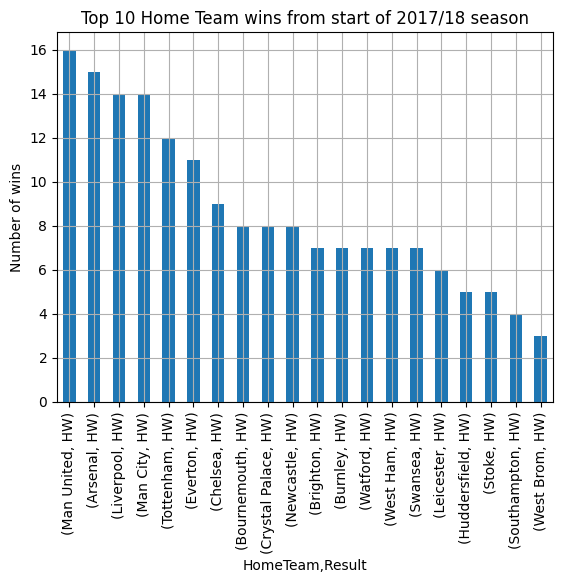

In [7]:
WINS = filtered_df.groupby('HomeTeam')['Result'].value_counts().sort_values(ascending = False).head(20).plot.bar()
plt.title('Top 10 Home Team wins from start of 2017/18 season')
plt.grid()
plt.ylabel('Number of wins')
plt.xticks(rotation =90)
plt.show()

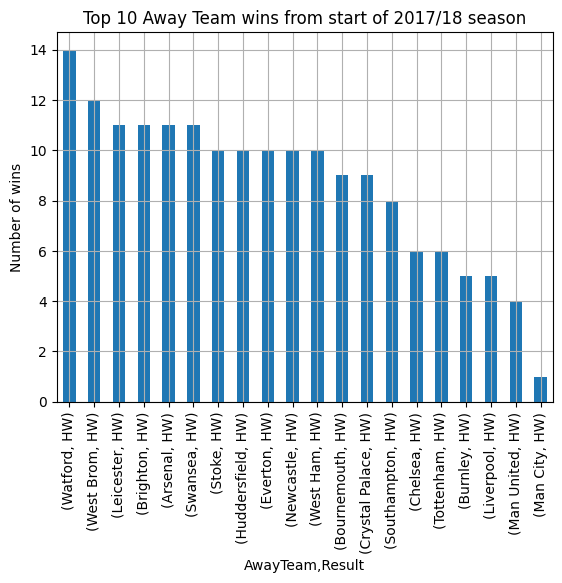

In [36]:
other_df = df.copy()

other_df = df[(df['Date'] > '2016-08-13') & (df['Result'] == 'AW')]

WINS = filtered_df.groupby('AwayTeam')['Result'].value_counts().sort_values(ascending = False).head(20).plot.bar()
plt.title('Top 10 Away Team wins from start of 2017/18 season')
plt.grid()
plt.ylabel('Number of wins')
plt.xticks(rotation =90)
plt.show()

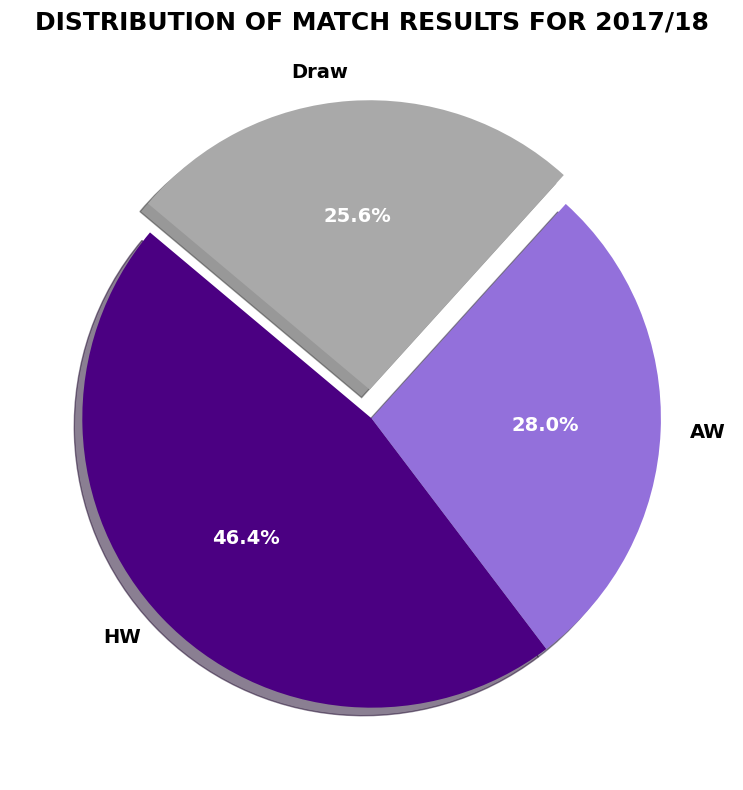

In [37]:
o_df = df.copy()
o_df['Result'] = np.where(
    o_df['FTHG'] > df['FTAG'], 'HW',
    np.where(
        df['FTHG'] < df['FTAG'], 'AW',
        'Draw'
    )
)


result_counts = o_df['Result'].value_counts()
labels = result_counts.index
sizes = result_counts.values


color_map = {
    'HW': '#4B0082',     # Dark Purple (Indigo)
    'AW': '#9370DB',     # Lilac (Medium Purple)
    'Draw': '#A9A9A9'    # Dark Gray
}
colors = [color_map[label] for label in labels]


explode = [0.1 if label == 'Draw' else 0 for label in labels]


fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14, 'weight': 'bold'}
)


plt.setp(autotexts, size=14, weight="bold", color='white')

plt.title("DISTRIBUTION OF MATCH RESULTS FOR 2017/18", fontsize=18, weight='bold', pad=20)

plt.tight_layout()
plt.show()

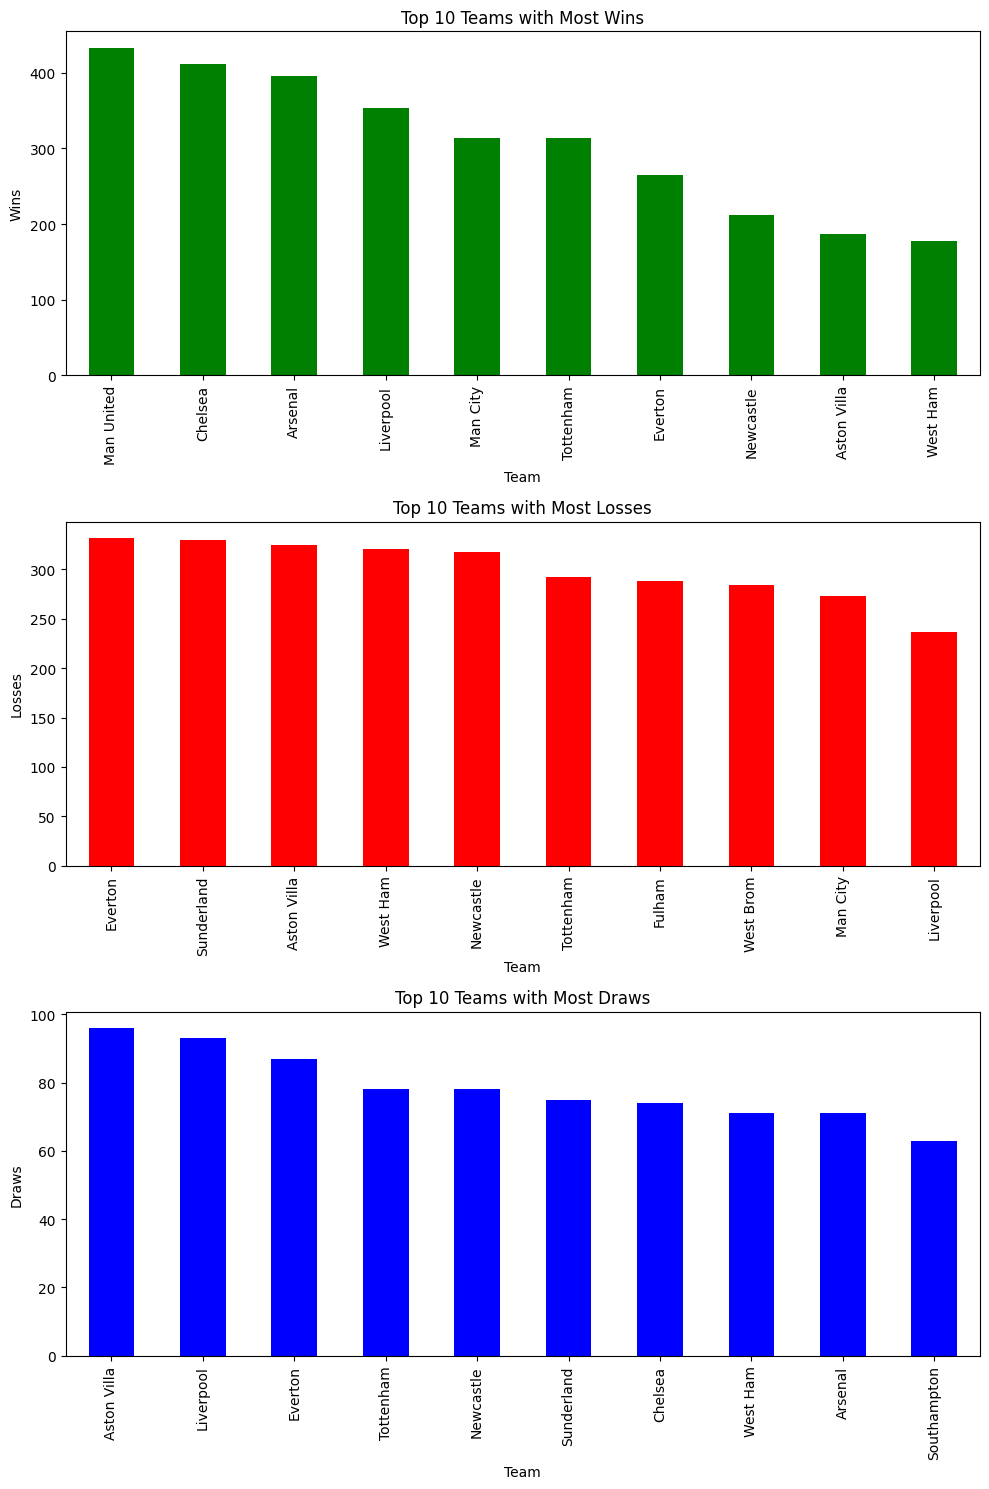

In [38]:


df['HomeWin'] = df['Result'] == 'HW'
df['AwayWin'] = df['Result'] == 'AW'
df['Draw'] = df['Result'] == 'Draw'


team_performance = {
    'team': [],
    'wins': [],
    'losses': [],
    'draws': []
}

for _, row in df.iterrows():

    home_team = row['HomeTeam']
    if row['HomeWin']:
        team_performance['team'].append(home_team)
        team_performance['wins'].append(1)
        team_performance['losses'].append(0)
        team_performance['draws'].append(0)
    elif row['Result'] == 'Draw':
        team_performance['team'].append(home_team)
        team_performance['wins'].append(0)
        team_performance['losses'].append(0)
        team_performance['draws'].append(1)
    else:
        team_performance['team'].append(home_team)
        team_performance['wins'].append(0)
        team_performance['losses'].append(1)
        team_performance['draws'].append(0)


    away_team = row['AwayTeam']
    if row['AwayWin']:
        team_performance['team'].append(away_team)
        team_performance['wins'].append(1)
        team_performance['losses'].append(0)
        team_performance['draws'].append(0)
    elif row['Result'] == 'DRAW':
        team_performance['team'].append(away_team)
        team_performance['wins'].append(0)
        team_performance['losses'].append(0)
        team_performance['draws'].append(1)
    else:
        team_performance['team'].append(away_team)
        team_performance['wins'].append(0)
        team_performance['losses'].append(1)
        team_performance['draws'].append(0)

performance_df = pd.DataFrame(team_performance)


team_stats = performance_df.groupby('team').sum()

top_10_wins = team_stats.sort_values('wins', ascending=False).head(10)
top_10_losses = team_stats.sort_values('losses', ascending=False).head(10)
top_10_draws = team_stats.sort_values('draws', ascending=False).head(10)


fig, ax = plt.subplots(3, 1, figsize=(10, 15))


top_10_wins['wins'].plot(kind='bar', ax=ax[0], color='green')
ax[0].set_title('Top 10 Teams with Most Wins')
ax[0].set_ylabel('Wins')
ax[0].set_xlabel('Team')


top_10_losses['losses'].plot(kind='bar', ax=ax[1], color='red')
ax[1].set_title('Top 10 Teams with Most Losses')
ax[1].set_ylabel('Losses')
ax[1].set_xlabel('Team')

top_10_draws['draws'].plot(kind='bar', ax=ax[2], color='blue')
ax[2].set_title('Top 10 Teams with Most Draws')
ax[2].set_ylabel('Draws')
ax[2].set_xlabel('Team')


plt.tight_layout()
plt.show()

Extracting the latest premier league season's data

In [39]:
frame = df.copy()
frame = frame[(df['Date'] >= '2016-08-13')]

Calculating and visualizing Average goals per game for each team

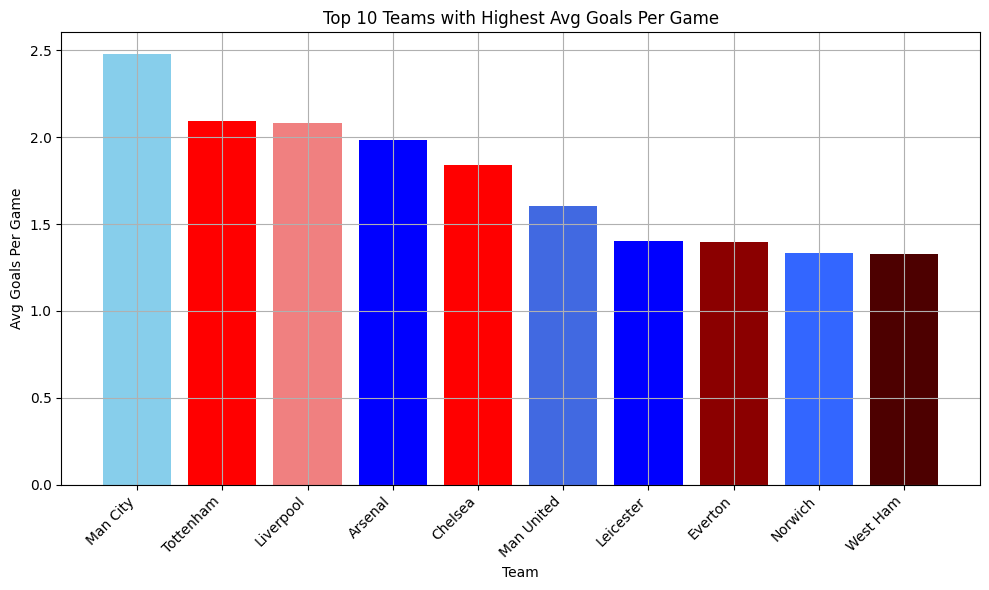

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

home_goals = frame.groupby('HomeTeam')['FTHG'].agg(['sum', 'count']).reset_index()
home_goals.columns = ['team', 'home_goals', 'home_games']

away_goals = frame.groupby('AwayTeam')['FTAG'].agg(['sum', 'count']).reset_index()
away_goals.columns = ['team', 'away_goals', 'away_games']

goals_df = pd.merge(home_goals, away_goals, on='team', how='outer').fillna(0)

goals_df['total_goals'] = goals_df['home_goals'] + goals_df['away_goals']
goals_df['total_games'] = goals_df['home_games'] + goals_df['away_games']
goals_df['avg_goals_per_game'] = goals_df['total_goals'] / goals_df['total_games']


top_10 = goals_df.sort_values('avg_goals_per_game', ascending=False).head(10)


custom_colors = [
    "skyblue",      # 1
    "red",       # 2
    "lightcoral",   # 3 (light red)
    "blue",         # 4
    "red",          # 5
    "royalblue",    # 6
    "blue",         # 7 (repeated)
    "darkred",      # 8 (burgundy)
    (0.2, 0.4, 1.0),  # 9 (blue-yellow-ish gradient approximation)
    (0.3, 0.0, 0.0)   # 10 (black-red gradient approximation)
]


plt.figure(figsize=(10, 6))
plt.bar(top_10['team'], top_10['avg_goals_per_game'], color=custom_colors[:len(top_10)])
plt.title('Top 10 Teams with Highest Avg Goals Per Game')
plt.xlabel('Team')
plt.ylabel('Avg Goals Per Game')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.tight_layout()
plt.show()



In [ ]:
goals_df[goals_df['team']=='Man City']

,team,home_goals,home_games,away_goals,away_games,total_goals,total_games,avg_goals_per_game
12,Man City,98,37,88.0,38.0,186.0,75.0,2.48


In [41]:
heat = frame.copy()

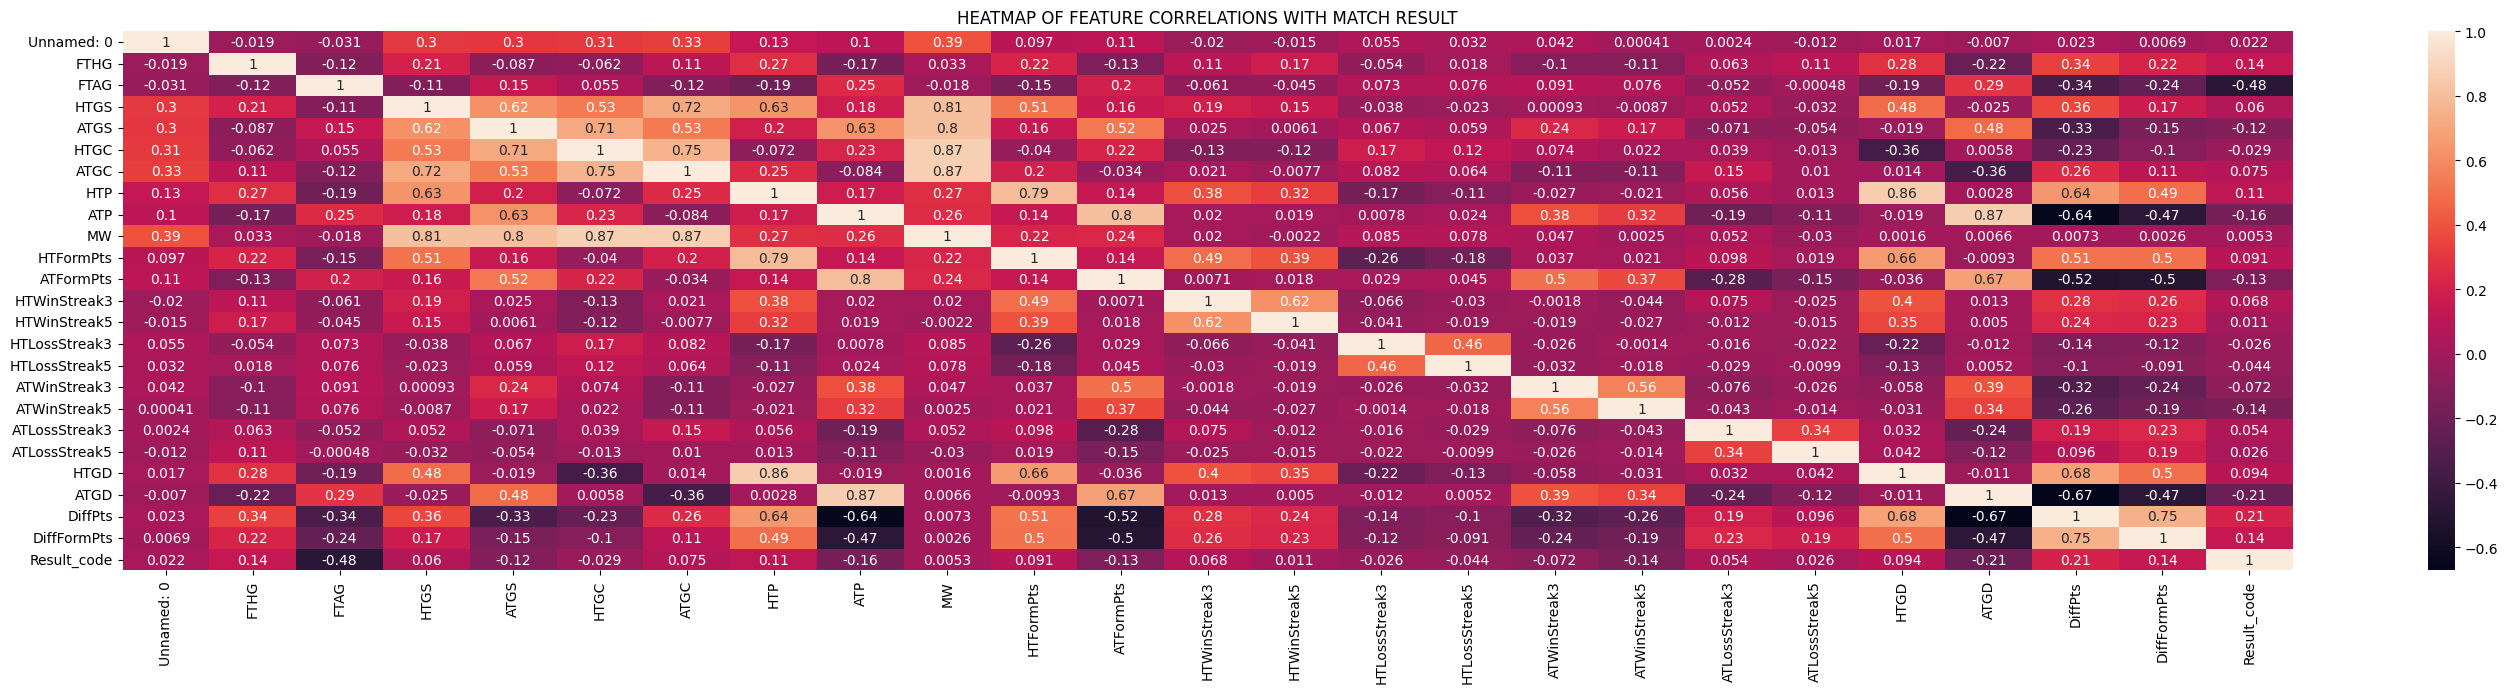

In [ ]:
heat['Result_code'] = heat['Result'].map({'HW':1, 'AW':0,'Draw':2})
heat = heat.select_dtypes(include= [float, int])

sns.heatmap(heat.corr(), annot=True)
plt.title('HEATMAP OF FEATURE CORRELATIONS WITH MATCH RESULT')
plt.rcParams['figure.figsize']=(35,7)
plt.show()

In [ ]:
# Compute correlations with Result_code
corr_with_result = heat.corr()['Result_code'].drop('Result_code')


top_corr = corr_with_result.reindex(corr_with_result.abs().sort_values(ascending=False).index).to_frame()

top_corr.head(10)


,Result_code
FTAG,-0.419248
Away_xG,-0.419248
Home_xG,0.136173
FTHG,0.136173
DiffPts,0.134068
ATP,-0.123073
ATFormPts,-0.119157
ATGD,-0.117278
DiffFormPts,0.063550
HTP,0.061366


PREPROCESSING FOR MODEL BUILDING

In [42]:
frame['Result_code'] = frame['Result'].map({'HW': 0, 'Draw': 1, 'AW': 2})

#team_list = sorted(set(df['HomeTeam']).union(df['AwayTeam']))

teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()


home_teams = pd.get_dummies(frame['HomeTeam'], prefix='home')
away_teams = pd.get_dummies(frame['AwayTeam'], prefix='away')

n_teams = len(teams)
n_classes = 3

features = ['HTP', 'DiffPts', 'HTGD', 'ATP', 'ATGD' ,'ATGS', 'DiffFormPts','ATFormPts']


scaler = StandardScaler()
frame[features] = scaler.fit_transform(frame[features])

X = pd.concat([home_teams, away_teams, frame[features]], axis=1).astype(float)
feature_columns = X.columns.tolist()
X = X.values
y = frame['Result_code'].values

# Reshape y to make it a 2D array as expected by OneHotEncoder
y = y.reshape(-1, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # sparse=False returns a dense array

# Fit and transform the target variable into one-hot encoding
y_onehot = encoder.fit_transform(y)

y_onehot = np.argmax(y_onehot, axis=1)

n_categories = 3
n_features = X.shape[1]



 DATA DISTRIBUTION BEFORE AND AFTER SCALING

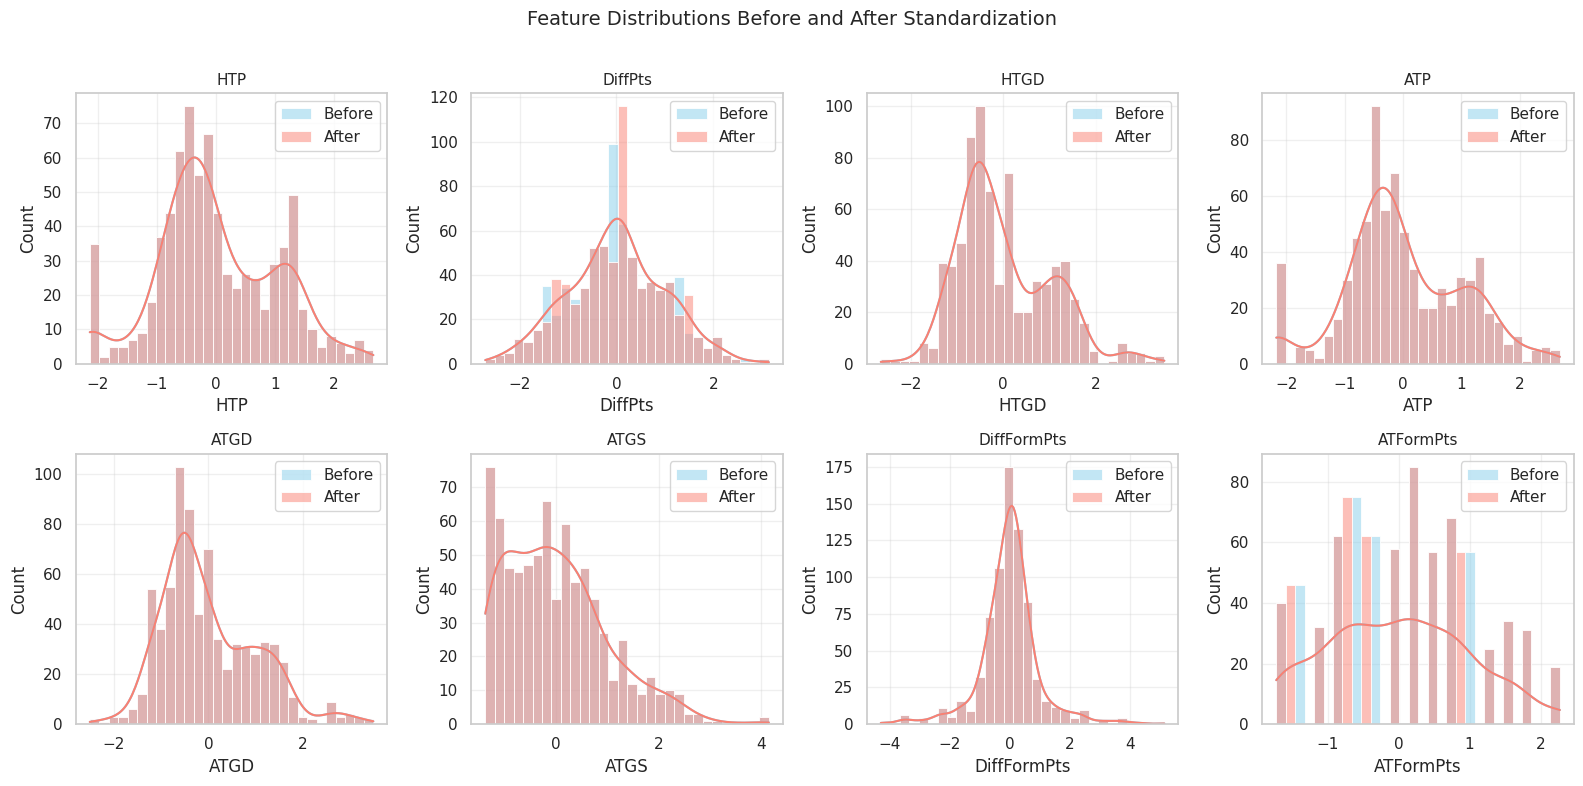

In [30]:


before_scaling = frame[features].copy()

scaler = StandardScaler()
after_scaling = pd.DataFrame(scaler.fit_transform(before_scaling), columns=features)


fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]


    sns.histplot(before_scaling[feature], bins=30, kde=True, color='skyblue', alpha=0.5, label='Before', ax=ax)

    sns.histplot(after_scaling[feature], bins=30, kde=True, color='salmon', alpha=0.5, label='After', ax=ax)

    ax.set_title(feature, fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions Before and After Standardization', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Hierarchical Bayesian Model

This model predicts match outcomes using team-specific random effects and covariates. Team abilities follow hierarchical priors with non-centered parameterization for computational efficiency:

\begin{align}
a_{\text{home},j} &= \mu_{\text{home}} + \sigma_{\text{home}} \cdot a_{\text{home,raw},j} \\
a_{\text{away},j} &= \mu_{\text{away}} + \sigma_{\text{away}} \cdot a_{\text{away,raw},j} \\
\text{home\_advantage}_j &= \mu_{\text{ha}} + \sigma_{\text{ha}} \cdot \text{ha}_{\text{raw},j}
\end{align}

where $a_{\text{home,raw},j}, a_{\text{away,raw},j}, \text{ha}_{\text{raw},j} \sim \mathcal{N}(0,1)$. The linear predictor for match $i$ is:

$$\boldsymbol{\eta}_i = \boldsymbol{\alpha} + \mathbf{X}_i \boldsymbol{\beta} + (a_{\text{home},h(i)} - a_{\text{away},a(i)}) + \text{home\_advantage}_{h(i)}$$

The likelihood uses multinomial logistic regression: $\mathbf{p}_i = \text{softmax}(\boldsymbol{\eta}_i)$ and $y_i \sim \text{Categorical}(\mathbf{p}_i)$.


**BUILDING BAYESIAN MODEL**


In [43]:
n_features = X.shape[1]
teams = sorted(teams)
team_to_idx = {team: idx for idx, team in enumerate(teams)}


home_team_idx = frame['HomeTeam'].map(team_to_idx).values
away_team_idx = frame['AwayTeam'].map(team_to_idx).values


with pm.Model() as hierarchical_model:

    mu_home = pm.Normal('mu_home', mu=0, sigma=1)
    sigma_home = pm.HalfNormal('sigma_home', 0.5)

    mu_away = pm.Normal('mu_away', mu=0, sigma=1)
    sigma_away = pm.HalfNormal('sigma_away', 0.5)

    mu_ha = pm.Normal('mu_ha', mu=0, sigma=1)
    sigma_ha = pm.HalfNormal('sigma_ha', 0.5)


    a_home_raw = pm.Normal('a_home_raw', mu=0, sigma=1, shape=n_teams)
    a_away_raw = pm.Normal('a_away_raw', mu=0, sigma=1, shape=n_teams)
    home_advantage_raw = pm.Normal('home_advantage_raw', mu=0, sigma=1, shape=n_teams)

    a_home = pm.Deterministic('a_home', mu_home + sigma_home * a_home_raw)
    a_away = pm.Deterministic('a_away', mu_away + sigma_away * a_away_raw)
    home_advantage = pm.Deterministic('home_advantage', mu_ha + sigma_ha * home_advantage_raw)


    beta = pm.Normal('beta', mu=0, sigma=1, shape=(X.shape[1], n_classes))
    intercept = pm.Normal('intercept',
                         mu=[0.61, -0.10, 0.0],
                         sigma=[0.2, 0.2, 0.2],
                         shape=(n_classes,))


    a_home_i = a_home[home_team_idx].reshape((-1, 1))
    a_away_i = a_away[away_team_idx].reshape((-1, 1))
    ha_i = home_advantage[home_team_idx].reshape((-1, 1))


    X_beta = pm.math.dot(X, beta)
    team_effects = (a_home_i - a_away_i) + ha_i
    logits = intercept[None, :] + X_beta + team_effects


    p = pm.math.softmax(logits, axis=1)
    pm.Deterministic("p", p)


    y_obs = pm.Categorical('y_obs', p=p, observed=y_onehot)




In [44]:
with hierarchical_model:
  prior_pred = pm.sample_prior_predictive(samples=100)

RELIABILTY ANALYSIS


Temperature Scaling was used to improve uncertainty calibration

Brier score (multiclass): 0.9745
Log loss: 2.2897


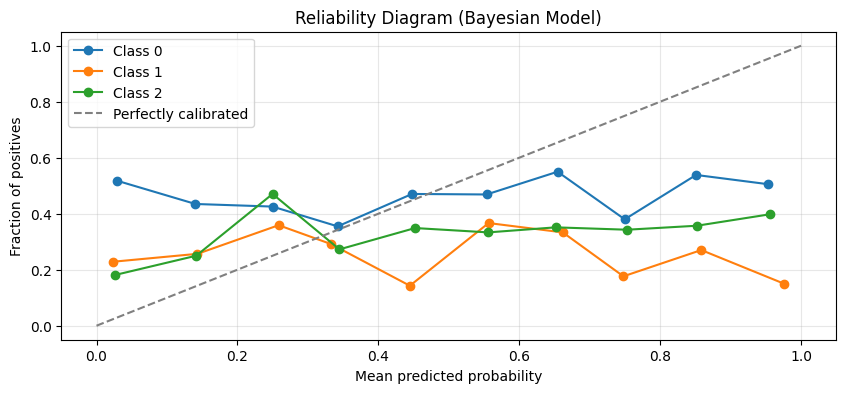

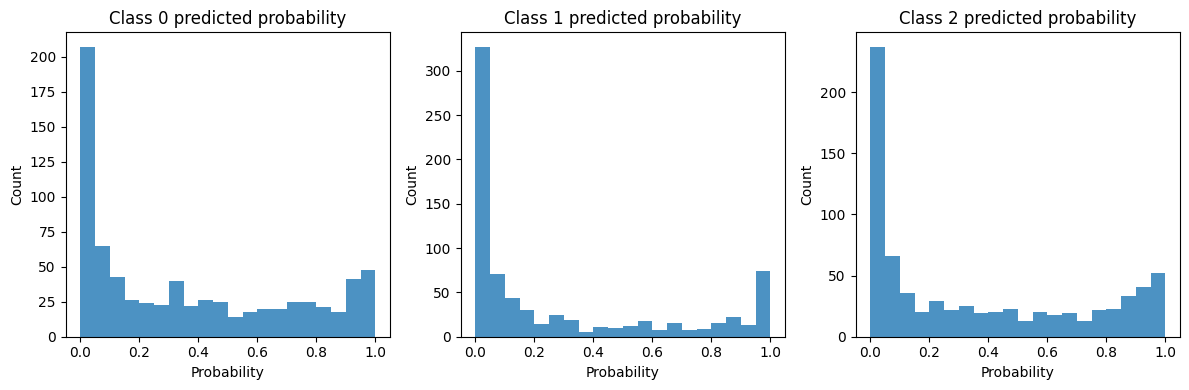

In [45]:
p_mean = p.eval()


y_true = frame['Result_code'].values
n_classes = p_mean.shape[1]


y_onehot = label_binarize(y_true, classes=list(range(n_classes)))


def brier_score_multiclass(y_true_onehot, probs):
    return np.mean(np.sum((probs - y_true_onehot)**2, axis=1))

brier = brier_score_multiclass(y_onehot, p_mean)
logloss = log_loss(y_true, p_mean)
print(f"Brier score (multiclass): {brier:.4f}")
print(f"Log loss: {logloss:.4f}")

from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 4))
for k in range(n_classes):
    prob_k = p_mean[:, k]
    true_k = y_onehot[:, k]
    prob_true, prob_pred = calibration_curve(true_k, prob_k, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {k}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (Bayesian Model)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 4))
for k in range(n_classes):
    plt.subplot(1, n_classes, k+1)
    plt.hist(p_mean[:, k], bins=20, range=(0,1), alpha=0.8)
    plt.title(f'Class {k} predicted probability')
    plt.xlabel('Probability')
    plt.ylabel('Count')
plt.tight_layout()

PRIOR PREDICTIVE *CHECKS*


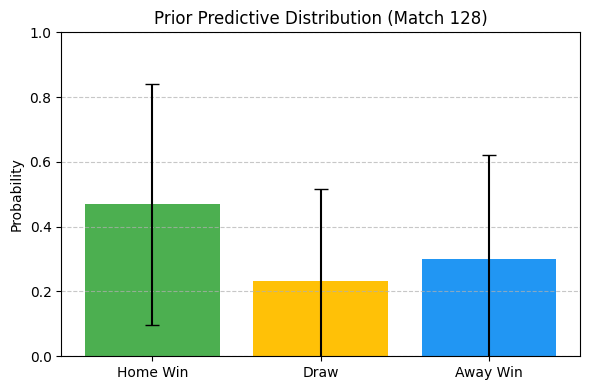

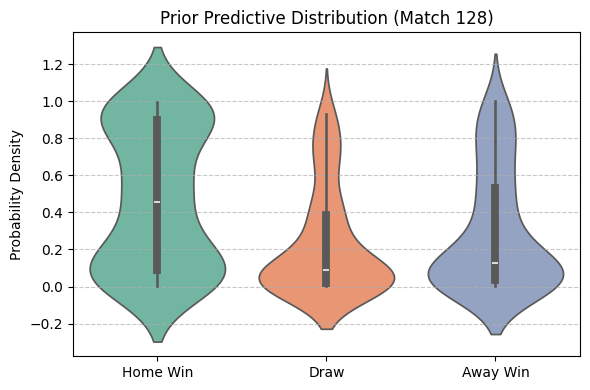

In [14]:

p_prior = prior_pred.prior['p'].stack(sample=("chain", "draw")).values
match_idx = 128

probs = p_prior[match_idx, :, :]
means = probs.mean(axis=1)
stds = probs.std(axis=1)

labels = ['Home Win', 'Draw', 'Away Win']
x = np.arange(3)

plt.figure(figsize=(6, 4))
plt.bar(x, means, yerr=stds, capsize=5, color=['#4CAF50', '#FFC107', '#2196F3'])
plt.xticks(x, labels)
plt.ylabel('Probability')
plt.title(f'Prior Predictive Distribution (Match {match_idx})')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
sns.violinplot(data=probs.T, palette='Set2')
plt.xticks(x, labels)
plt.ylabel('Probability Density')
plt.title(f'Prior Predictive Distribution (Match {match_idx})')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

SIMULATING OUTCOMES GIVEN THE PRIOR **SETTING**

(1, 100, 751)


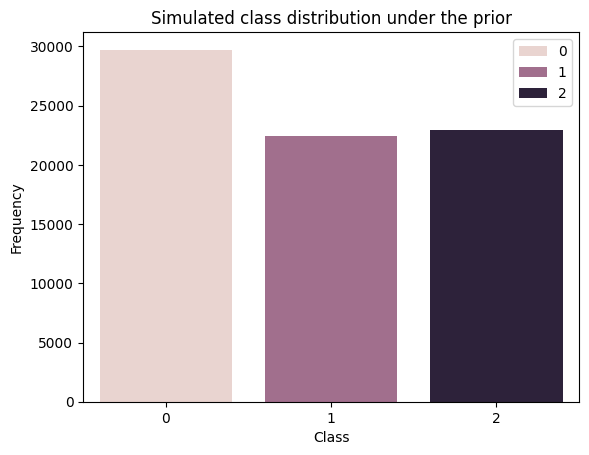

In [15]:


fake_obs = prior_pred.prior_predictive['y_obs']
print(fake_obs.shape)

flat_y = fake_obs.values.flatten()
sns.countplot(x=flat_y,hue=flat_y)
plt.title("Simulated class distribution under the prior")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

*MODEL SAMPLING*


In [48]:
with hierarchical_model:
      trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Output()

In [64]:
import numpy as np

def evaluate_model_performance(trace, X, y, home_team_idx, away_team_idx):

    # Extracting posterior samples
    intercept_samples = trace.posterior['intercept'].stack(sample=('chain', 'draw')).values.T
    beta_samples = trace.posterior['beta'].stack(sample=('chain', 'draw')).values
    beta_samples = beta_samples.transpose(2, 0, 1)
    a_home_samples = trace.posterior['a_home'].stack(sample=('chain', 'draw')).values.T
    a_away_samples = trace.posterior['a_away'].stack(sample=('chain', 'draw')).values.T
    ha_samples = trace.posterior['home_advantage'].stack(sample=('chain', 'draw')).values.T

    n_samples = min(1000, intercept_samples.shape[0])
    n_matches = X.shape[0]


    all_predictions = np.zeros((n_matches, n_samples, 3))

    for i in range(n_matches):
        x_i = X[i:i+1, :]
        h_idx = home_team_idx[i]
        a_idx = away_team_idx[i]

        for s in range(n_samples):
            intercept = intercept_samples[s]
            beta = beta_samples[s]
            a_home = a_home_samples[s, h_idx]
            a_away = a_away_samples[s, a_idx]
            home_adv = ha_samples[s, h_idx]

            fixed_effects = np.dot(x_i, beta).flatten()
            team_effects = (a_home - a_away) + home_adv
            logits = intercept + fixed_effects + team_effects


            probs = np.exp(logits) / np.sum(np.exp(logits))
            all_predictions[i, s, :] = probs


    predicted_classes = np.argmax(mean_predictions, axis=1)
    accuracy = np.mean(predicted_classes == y)

    epistemic = np.mean(np.var(all_predictions, axis=1))


    mean_probs = np.mean(all_predictions, axis=1)
    entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    aleatoric = np.mean(entropy)


    total_uncertainty = epistemic + aleatoric

    print("="*60)
    print("MODEL PERFORMANCE METRICS")
    print("="*60)
    print(f"Overall Accuracy:           {accuracy:.2%}")
    print(f"Epistemic Uncertainty:      {epistemic:.4f}")
    print(f"Aleatoric Uncertainty:      {aleatoric:.4f}")
    print(f"Total Uncertainty:          {total_uncertainty:.4f}")
    print("="*60)

    # Breakdown by outcome
    print("\nAccuracy by Outcome:")
    y_flat = y.flatten() if y.ndim > 1 else y
    for outcome_idx, outcome_name in enumerate(['Home Win', 'Draw', 'Away Win']):
        mask = (y_flat == outcome_idx)
        if mask.sum() > 0:
            outcome_acc = np.mean(predicted_classes[mask] == outcome_idx)
            print(f"  {outcome_name:15s}: {outcome_acc:.2%} ({mask.sum()} matches)")

    print("\n" + "="*60)

    return {
        'accuracy': accuracy,
        'epistemic_uncertainty': epistemic,
        'aleatoric_uncertainty': aleatoric,
        'total_uncertainty': total_uncertainty,
        'mean_predictions': mean_predictions,
        'predicted_classes': predicted_classes
    }


results = evaluate_model_performance(trace, X, y, home_team_idx, away_team_idx)

MODEL PERFORMANCE METRICS
Overall Accuracy:           40.62%
Epistemic Uncertainty:      0.0117
Aleatoric Uncertainty:      0.8889
Total Uncertainty:          0.9007

Accuracy by Outcome:
  Home Win       : 83.84% (359 matches)
  Draw           : 10.06% (179 matches)
  Away Win       : 61.97% (213 matches)



FEATURE IMPORTANCE VIZUALIZATIONS

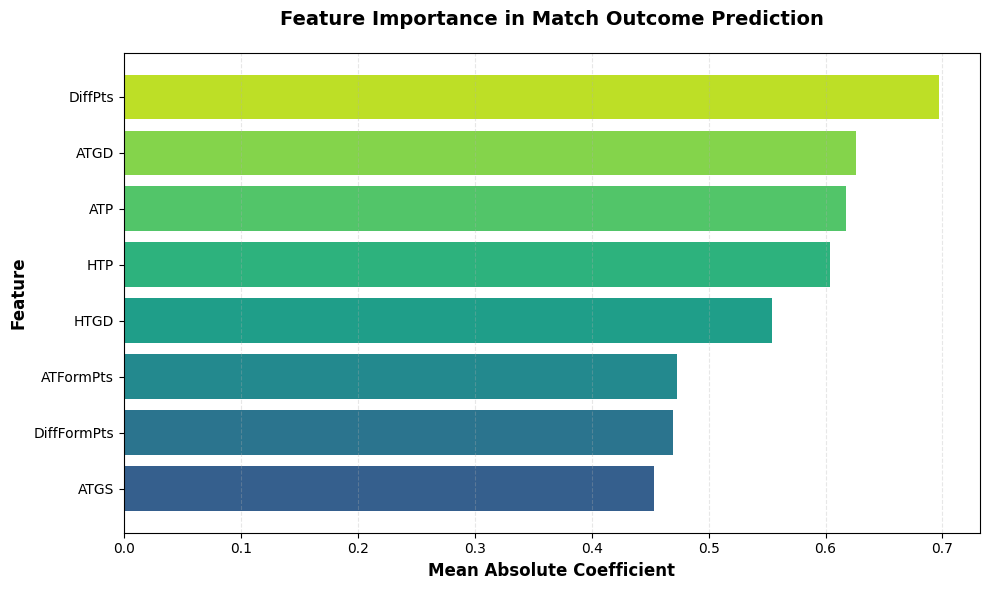


Feature Importance Rankings:
DiffPts             : 0.6972
ATGD                : 0.6258
ATP                 : 0.6173
HTP                 : 0.6041
HTGD                : 0.5543
ATFormPts           : 0.4726
DiffFormPts         : 0.4697
ATGS                : 0.4536


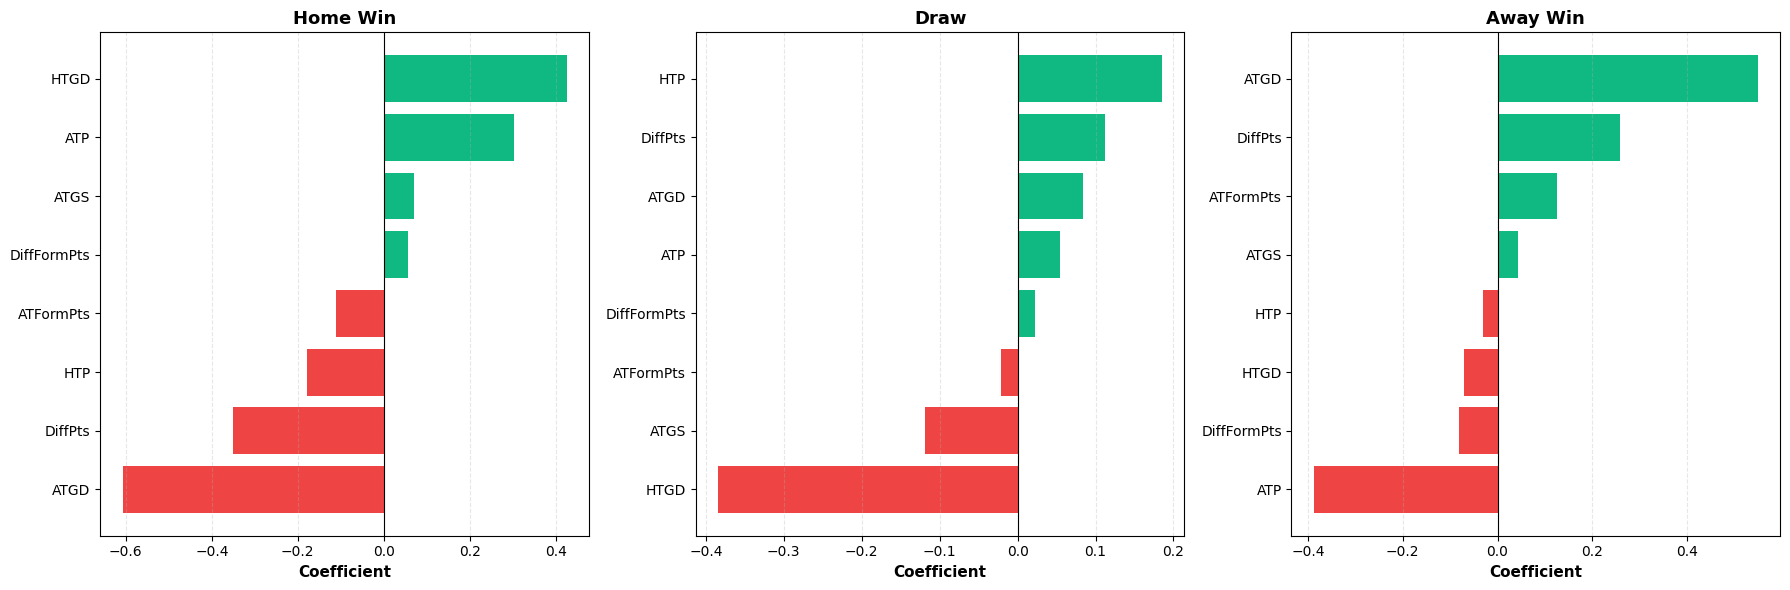

array([[-0.17806226,  0.18559209, -0.03027136],
       [-0.35034751,  0.11192717,  0.25962824],
       [ 0.4254935 , -0.38417424, -0.07017586],
       [ 0.30371369,  0.05418797, -0.38807768],
       [-0.6076281 ,  0.08395372,  0.54958329],
       [ 0.06949543, -0.11819772,  0.04312373],
       [ 0.05607044,  0.0220653 , -0.08190165],
       [-0.11163939, -0.02145628,  0.12640612]])

In [ ]:
def plot_feature_importance(trace, feature_columns, top_n=15):



    beta_samples = trace.posterior['beta'].stack(sample=('chain', 'draw')).values
    beta_samples = beta_samples.transpose(2, 0, 1)


    mean_abs_beta = np.mean(np.abs(beta_samples), axis=(0, 2))


    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': mean_abs_beta
    })


    importance_df = importance_df[~importance_df['Feature'].str.startswith('home_')]
    importance_df = importance_df[~importance_df['Feature'].str.startswith('away_')]


    importance_df = importance_df.sort_values('Importance', ascending=True).tail(top_n)

    fig, ax = plt.subplots(figsize=(10, 6))

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
    ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)

    ax.set_xlabel('Mean Absolute Coefficient', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
    ax.set_title('Feature Importance in Match Outcome Prediction',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    print("\nFeature Importance Rankings:")
    print("=" * 50)
    for idx, row in importance_df.sort_values('Importance', ascending=False).iterrows():
        print(f"{row['Feature']:20s}: {row['Importance']:.4f}")

    return importance_df


def plot_feature_importance_by_outcome(trace, feature_columns, top_n=10):

    beta_samples = trace.posterior['beta'].stack(sample=('chain', 'draw')).values
    beta_samples = beta_samples.transpose(2, 0, 1)


    mean_beta = np.mean(beta_samples, axis=0)

    outcomes = ['Home Win', 'Draw', 'Away Win']

    mask = [not (col.startswith('home_') or col.startswith('away_'))
            for col in feature_columns]
    filtered_features = [f for f, m in zip(feature_columns, mask) if m]
    filtered_beta = mean_beta[mask, :]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (ax, outcome) in enumerate(zip(axes, outcomes)):

        coefs = filtered_beta[:, i]

        df = pd.DataFrame({
            'Feature': filtered_features,
            'Coefficient': coefs
        }).sort_values('Coefficient', ascending=True).tail(top_n)


        colors = ['#ef4444' if x < 0 else '#10b981' for x in df['Coefficient']]

        ax.barh(df['Feature'], df['Coefficient'], color=colors)
        ax.set_xlabel('Coefficient', fontsize=11, fontweight='bold')
        ax.set_title(outcome, fontsize=13, fontweight='bold')
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

    plt.tight_layout()
    plt.show()

    return filtered_beta

plot_feature_importance(trace, feature_columns)
plot_feature_importance_by_outcome(trace, feature_columns)

MODEL TRACEPLOTS

/tmp/ipython-input-2509881675.py:4: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


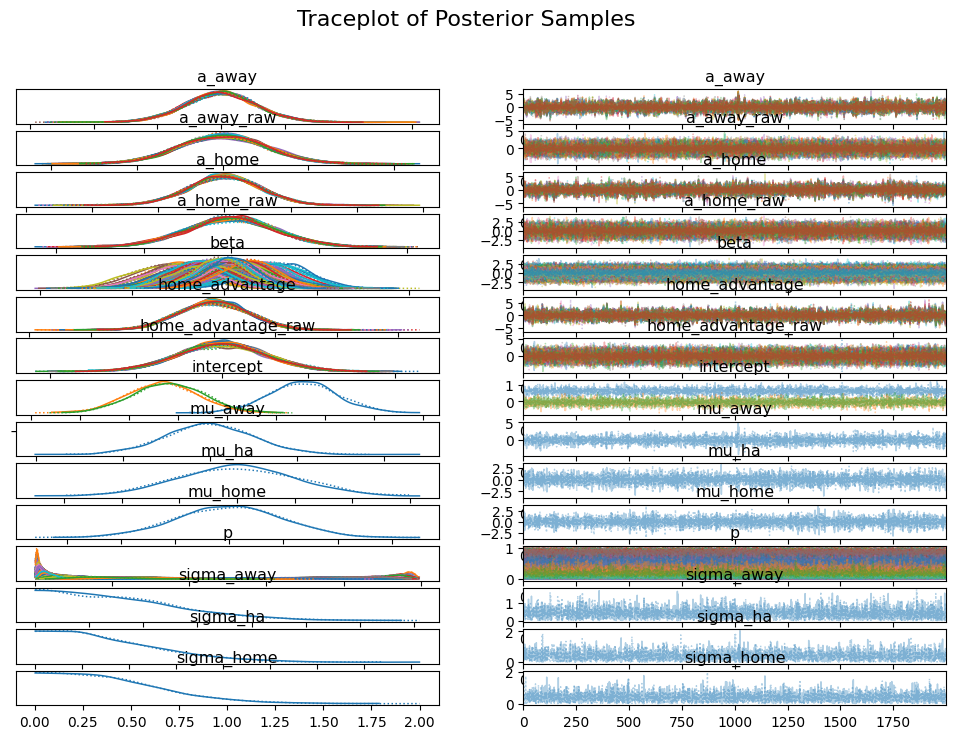

In [ ]:

az.plot_trace(trace, figsize=(12, 8))
plt.suptitle("Traceplot of Posterior Samples", fontsize=16)
plt.tight_layout()
plt.show()

#*Graphical Representation of the model*

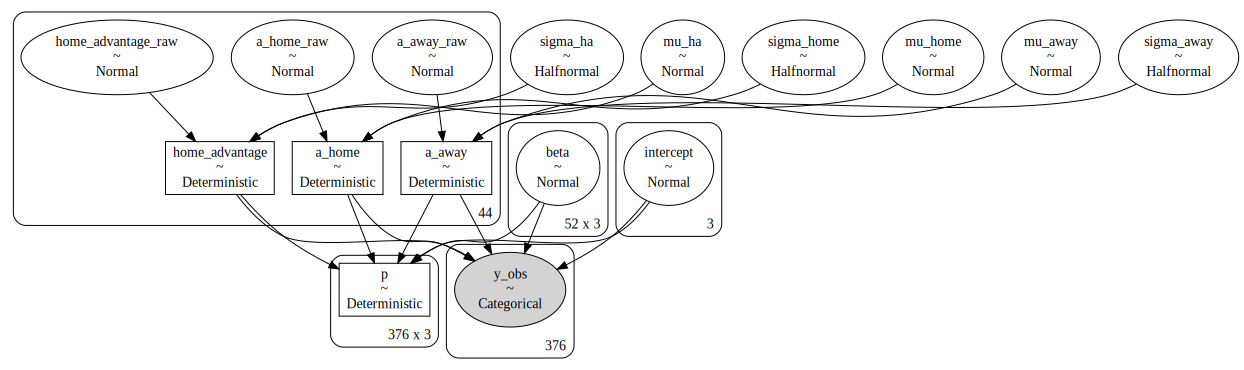

In [ ]:
pm.model_to_graphviz(hierarchical_model)

*MODEL PREDICTION AUTOMATION*

In [17]:
def predict_match_with_uncertainty(home_team, away_team, trace, team_list, frame, scaler, feature_columns, n_samples=1000):
    if feature_columns is None:
        feature_columns = ['HTP', 'DiffPts', 'HTGD', 'ATP', 'ATGD', 'ATGS', 'DiffFormPts', 'ATFormPts']


    home_idx = team_list.index(home_team)
    away_idx = team_list.index(away_team)


    home_vec = pd.get_dummies([home_team], prefix='home', dtype=int)
    away_vec = pd.get_dummies([away_team], prefix='away', dtype=int)
    home_vec = home_vec.reindex(columns=[f'home_{t}' for t in team_list], fill_value=0)
    away_vec = away_vec.reindex(columns=[f'away_{t}' for t in team_list], fill_value=0)


    def compute_match_features(home_team, away_team, frame):
        home_row = frame[frame['HomeTeam'] == home_team].iloc[-1]
        away_row = frame[frame['AwayTeam'] == away_team].iloc[-1]
        return {
            'HTP': home_row['HTP'], 'DiffPts': home_row['DiffPts'], 'HTGD': home_row['HTGD'],
            'ATP': away_row['ATP'], 'ATGD': away_row['ATGD'], 'ATGS': away_row['ATGS'],
            'DiffFormPts': home_row['DiffFormPts'], 'ATFormPts': away_row['ATFormPts']
        }

    features_dict = compute_match_features(home_team, away_team, frame)
    cont_features = pd.DataFrame([features_dict])
    cont_scaled = pd.DataFrame(scaler.transform(cont_features), columns=cont_features.columns)


    x_df = pd.concat([home_vec, away_vec, cont_scaled], axis=1)
    x_df = x_df.reindex(columns=feature_columns, fill_value=0)
    x_new = x_df.astype(float).values


    intercept_samples = trace.posterior['intercept'].stack(sample=('chain', 'draw')).values.T
    beta_samples = trace.posterior['beta'].stack(sample=('chain', 'draw')).values
    beta_samples = beta_samples.transpose(2, 0, 1)
    a_home_samples = trace.posterior['a_home'].stack(sample=('chain', 'draw')).values.T
    a_away_samples = trace.posterior['a_away'].stack(sample=('chain', 'draw')).values.T
    ha_samples = trace.posterior['home_advantage'].stack(sample=('chain', 'draw')).values.T


    total_samples = intercept_samples.shape[0]
    sample_idx = np.random.choice(total_samples, min(n_samples, total_samples), replace=False)

    predictions = []
    for idx in sample_idx:

        intercept = intercept_samples[idx]
        beta = beta_samples[idx]
        a_home = a_home_samples[idx, home_idx]
        a_away = a_away_samples[idx, away_idx]
        home_advantage = ha_samples[idx, home_idx]


        fixed_effects = np.dot(x_new, beta).flatten()
        team_effects = (a_home - a_away) + home_advantage
        logits = intercept + fixed_effects + team_effects


        probs = np.exp(logits) / np.sum(np.exp(logits))
        predictions.append(probs)

    predictions = np.array(predictions)

    mean_probs = np.mean(predictions, axis=0)
    lower_95 = np.percentile(predictions, 2.5, axis=0)
    upper_95 = np.percentile(predictions, 97.5, axis=0)


    outcomes = ['Home Win', 'Draw', 'Away Win']
    results = {}

    print(f"\nPrediction: {home_team} vs {away_team}")
    print("=" * 50)

    for i, outcome in enumerate(outcomes):
        results[outcome] = {
            'mean': float(mean_probs[i]),
            'ci_lower': float(lower_95[i]),
            'ci_upper': float(upper_95[i])
        }
        print(f"{outcome}: {mean_probs[i]:.3f}")
        print(f"  → 95% sure that {outcome.lower()} probability is between {lower_95[i]:.3f} and {upper_95[i]:.3f}")

    return results


In [24]:
predict_match_with_uncertainty("Arsenal", "Everton", trace, team_list=teams, frame=frame, scaler=scaler, feature_columns=feature_columns)


Prediction: Arsenal vs Everton
Home Win: 0.846
  → 95% sure that home win probability is between 0.612 and 0.969
Draw: 0.088
  → 95% sure that draw probability is between 0.012 and 0.268
Away Win: 0.065
  → 95% sure that away win probability is between 0.008 and 0.215


{'Home Win': {'mean': 0.8464136968307291,
  'ci_lower': 0.6122421552328344,
  'ci_upper': 0.9689261242467484},
 'Draw': {'mean': 0.0882310669312086,
  'ci_lower': 0.011674112693007456,
  'ci_upper': 0.26825899850082296},
 'Away Win': {'mean': 0.0653552362380617,
  'ci_lower': 0.007972358244043647,
  'ci_upper': 0.21477674348450596}}

# EXPLAINING MODEL PREDICTIONS

In [25]:
def explain_prediction(home_team, away_team, trace, team_list, frame, scaler, feature_columns):
    """
    Break down a prediction to show what's driving the outcome
    """
    if feature_columns is None:
        feature_columns = ['HTP', 'DiffPts', 'HTGD', 'ATP', 'ATGD', 'ATGS', 'DiffFormPts', 'ATFormPts']


    home_idx = team_list.index(home_team)
    away_idx = team_list.index(away_team)


    home_vec = pd.get_dummies([home_team], prefix='home', dtype=int)
    away_vec = pd.get_dummies([away_team], prefix='away', dtype=int)
    home_vec = home_vec.reindex(columns=[f'home_{t}' for t in team_list], fill_value=0)
    away_vec = away_vec.reindex(columns=[f'away_{t}' for t in team_list], fill_value=0)


    def compute_match_features(home_team, away_team, frame):
        home_row = frame[frame['HomeTeam'] == home_team].iloc[-1]
        away_row = frame[frame['AwayTeam'] == away_team].iloc[-1]
        return {
            'HTP': home_row['HTP'], 'DiffPts': home_row['DiffPts'], 'HTGD': home_row['HTGD'],
            'ATP': away_row['ATP'], 'ATGD': away_row['ATGD'], 'ATGS': away_row['ATGS'],
            'DiffFormPts': home_row['DiffFormPts'], 'ATFormPts': away_row['ATFormPts']
        }

    features_dict = compute_match_features(home_team, away_team, frame)
    cont_features = pd.DataFrame([features_dict])
    cont_scaled = pd.DataFrame(scaler.transform(cont_features), columns=cont_features.columns)

    x_df = pd.concat([home_vec, away_vec, cont_scaled], axis=1)
    x_df = x_df.reindex(columns=feature_columns, fill_value=0)
    x_new = x_df.astype(float).values


    intercept_mean = trace.posterior['intercept'].mean(("chain", "draw")).values
    beta_mean = trace.posterior['beta'].mean(("chain", "draw")).values
    a_home_mean = trace.posterior['a_home'].mean(("chain", "draw")).values[home_idx]
    a_away_mean = trace.posterior['a_away'].mean(("chain", "draw")).values[away_idx]
    ha_mean = trace.posterior['home_advantage'].mean(("chain", "draw")).values[home_idx]


    team_strength_diff = a_home_mean - a_away_mean
    home_advantage_effect = ha_mean


    feature_effects = {}
    for i, feat in enumerate(feature_columns):
        if not (feat.startswith('home_') or feat.startswith('away_')):
            effect = x_new[0, i] * beta_mean[i, 0]
            feature_effects[feat] = effect


    sorted_features = sorted(feature_effects.items(), key=lambda x: abs(x[1]), reverse=True)


    baseline_logits = intercept_mean
    baseline_probs = np.exp(baseline_logits) / np.sum(np.exp(baseline_logits))


    fixed_effects = np.dot(x_new, beta_mean).flatten()
    team_effects = team_strength_diff + home_advantage_effect
    logits = intercept_mean + fixed_effects + team_effects
    probs = np.exp(logits) / np.sum(np.exp(logits))


    print(f"\n{'='*60}")
    print(f"PREDICTION BREAKDOWN: {home_team} vs {away_team}")
    print(f"{'='*60}\n")

    print(f"Final Prediction:")
    print(f"  Home Win: {probs[0]:.1%}")
    print(f"  Draw:     {probs[1]:.1%}")
    print(f"  Away Win: {probs[2]:.1%}")

    print(f"\n{'-'*60}")
    print(f"CONTRIBUTION ANALYSIS (Home Win Probability)")
    print(f"{'-'*60}\n")

    print(f"1. Baseline (League Average):        {baseline_probs[0]:.1%}")
    print(f"\n2. Team Quality Effects:")
    print(f"   • Team Strength Gap:              {team_strength_diff:+.3f}")
    print(f"   • Home Advantage:                 {home_advantage_effect:+.3f}")
    print(f"   Combined Team Effect:             {team_effects:+.3f}")

    print(f"\n3. Match-Specific Features:")
    for feat, effect in sorted_features[:5]:  # Top 5 features
        print(f"   • {feat:20s}:        {effect:+.3f}")

    print(f"\n{'-'*60}")
    print(f"INTERPRETATION:")
    print(f"{'-'*60}")

    # Automatic interpretation
    if probs[0] > 0.7:
        confidence = "High confidence"
    elif probs[0] > 0.5:
        confidence = "Moderate confidence"
    else:
        confidence = "Low confidence"

    if abs(team_effects) > 0.5:
        main_driver = "team quality difference"
    elif abs(sorted_features[0][1]) > 0.3:
        main_driver = f"{sorted_features[0][0]}"
    else:
        main_driver = "multiple small factors"

    print(f"{confidence} in home win.")
    print(f"Primary driver: {main_driver}")

    if abs(team_strength_diff) > 1.0:
        print(f"Large team quality gap detected ({abs(team_strength_diff):.2f}).")

    print(f"\n{'='*60}\n")

    return {
        'probabilities': probs,
        'team_effects': team_effects,
        'feature_contributions': sorted_features,
        'baseline': baseline_probs[0]
    }


explain_prediction("Arsenal", "Bournemouth", trace, teams, frame, scaler, feature_columns)


PREDICTION BREAKDOWN: Arsenal vs Bournemouth

Final Prediction:
  Home Win: 86.8%
  Draw:     6.2%
  Away Win: 7.0%

------------------------------------------------------------
CONTRIBUTION ANALYSIS (Home Win Probability)
------------------------------------------------------------

1. Baseline (League Average):        50.3%

2. Team Quality Effects:
   • Team Strength Gap:              +0.021
   • Home Advantage:                 -0.018
   Combined Team Effect:             +0.003

3. Match-Specific Features:
   • ATP                 :        -0.807
   • HTGD                :        +0.467
   • ATGD                :        +0.450
   • ATFormPts           :        +0.213
   • HTP                 :        +0.144

------------------------------------------------------------
INTERPRETATION:
------------------------------------------------------------
High confidence in home win.
Primary driver: ATP




{'probabilities': array([0.8682592 , 0.06220801, 0.06953279]),
 'team_effects': np.float64(0.0026625383284231766),
 'feature_contributions': [('ATP', np.float64(-0.8066353945083182)),
  ('HTGD', np.float64(0.4674436776405255)),
  ('ATGD', np.float64(0.4497779115232342)),
  ('ATFormPts', np.float64(0.21298548370007095)),
  ('HTP', np.float64(0.14375670059364762)),
  ('DiffPts', np.float64(-0.13056365398139816)),
  ('ATGS', np.float64(-0.09786911206760182)),
  ('DiffFormPts', np.float64(0.012082001179912918))],
 'baseline': np.float64(0.5028871167471138)}

# MATCH OUTCOME VIZUALISATIONS


Prediction: Arsenal vs Everton
Home Win: 0.839
  → 95% sure that home win probability is between 0.583 and 0.968
Draw: 0.094
  → 95% sure that draw probability is between 0.012 and 0.308
Away Win: 0.067
  → 95% sure that away win probability is between 0.008 and 0.224


/tmp/ipython-input-3524297481.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=outcomes, y=probabilities, palette="viridis")


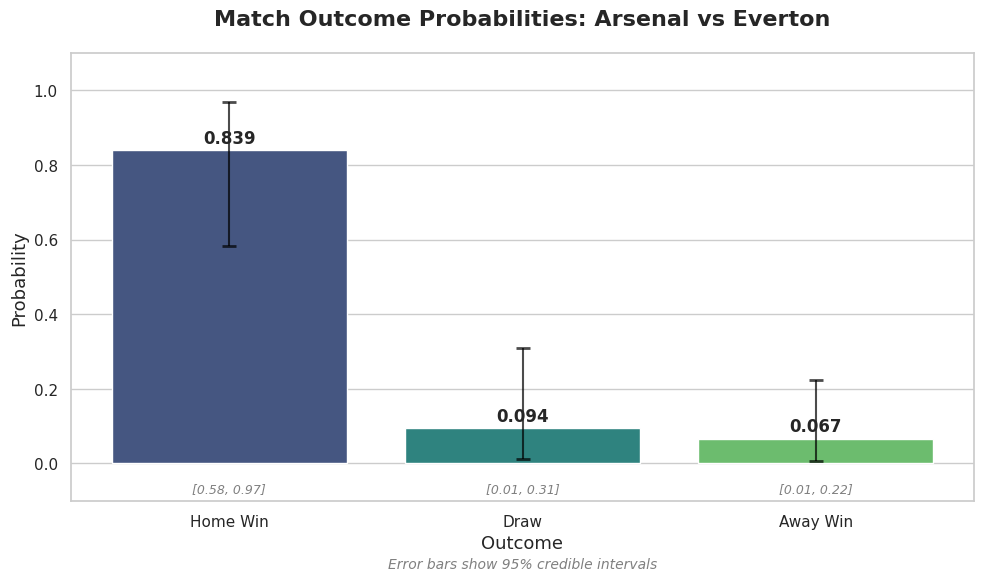

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_match_prediction(home_team, away_team, trace, team_list, frame, scaler, feature_columns):

    results = predict_match_with_uncertainty(home_team, away_team, trace, team_list, frame, scaler, feature_columns)


    outcomes = list(results.keys())
    probabilities = [results[outcome]['mean'] for outcome in outcomes]
    ci_lower = [results[outcome]['ci_lower'] for outcome in outcomes]
    ci_upper = [results[outcome]['ci_upper'] for outcome in outcomes]


    errors = [[probabilities[i] - ci_lower[i] for i in range(len(outcomes))],
              [ci_upper[i] - probabilities[i] for i in range(len(outcomes))]]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))


    ax = sns.barplot(x=outcomes, y=probabilities, palette="viridis")


    x_pos = range(len(outcomes))
    plt.errorbar(x_pos, probabilities, yerr=errors, fmt='none', ecolor='black',
                 capsize=5, capthick=2, alpha=0.7)


    for i, prob in enumerate(probabilities):
        ax.text(i, prob + 0.02, f"{prob:.3f}", ha='center', fontsize=12, fontweight='bold')

        ax.text(i, -0.08, f"[{ci_lower[i]:.2f}, {ci_upper[i]:.2f}]",
                ha='center', fontsize=9, style='italic', color='gray')

    plt.ylim(-0.1, 1.1)
    plt.title(f"Match Outcome Probabilities: {home_team} vs {away_team}",
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel("Probability", fontsize=13)
    plt.xlabel("Outcome", fontsize=13)


    plt.text(0.5, -0.15, "Error bars show 95% credible intervals",
             ha='center', transform=ax.transAxes, fontsize=10, style='italic', color='gray')

    plt.tight_layout()
    plt.show()


plot_match_prediction("Arsenal", "Everton", trace, team_list=teams, frame=frame, scaler=scaler, feature_columns=feature_columns)


*POSTERIOR DISTRUBTION PREDICTION*

In [ ]:
def predict_posterior_distribution(home_team, away_team, trace, team_list, frame, scaler, feature_columns):

    match = frame[(frame['HomeTeam'] == home_team) & (frame['AwayTeam'] == away_team)].iloc[-1]

    features = {
        'HTP': match['HTP'],
        'DiffPts': match['DiffPts'],
        'HTGD': match['HTGD'],
        'ATP': match['ATP'],
        'ATGD': match['ATGD'],
        'ATGS': match['ATGS'],
        'DiffFormPts': match['DiffFormPts'],
        'ATFormPts': match['ATFormPts']
    }

    home_vec = pd.get_dummies([home_team], prefix='home', dtype=int).reindex(columns=[f'home_{t}' for t in team_list], fill_value=0)
    away_vec = pd.get_dummies([away_team], prefix='away', dtype=int).reindex(columns=[f'away_{t}' for t in team_list], fill_value=0)

    cont_features = pd.DataFrame([features])
    cont_features_scaled = pd.DataFrame(scaler.transform(cont_features), columns=cont_features.columns)

    x_df = pd.concat([home_vec, away_vec, cont_features_scaled], axis=1)
    x_df = x_df.reindex(columns=feature_columns, fill_value=0)
    x_new = x_df.values

    beta_samples = trace.posterior['beta'].stack(sample=("chain", "draw")).values
    intercept_samples = trace.posterior['intercept'].stack(sample=("chain", "draw")).values.T

    logits = np.einsum('ij,jks->iks', x_new, beta_samples)
    logits = logits[0].T + intercept_samples

    logits = np.clip(logits, -10, 10)


    exp_logits = np.exp(logits)
    p = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return p



In [ ]:
p_posterior = predict_posterior_distribution("Arsenal", "Chelsea", trace, team_list=teams, frame=frame, scaler=scaler, feature_columns=feature_columns)


#*MATCH OUTCOME POSTERIOR DISTRIBUTION*

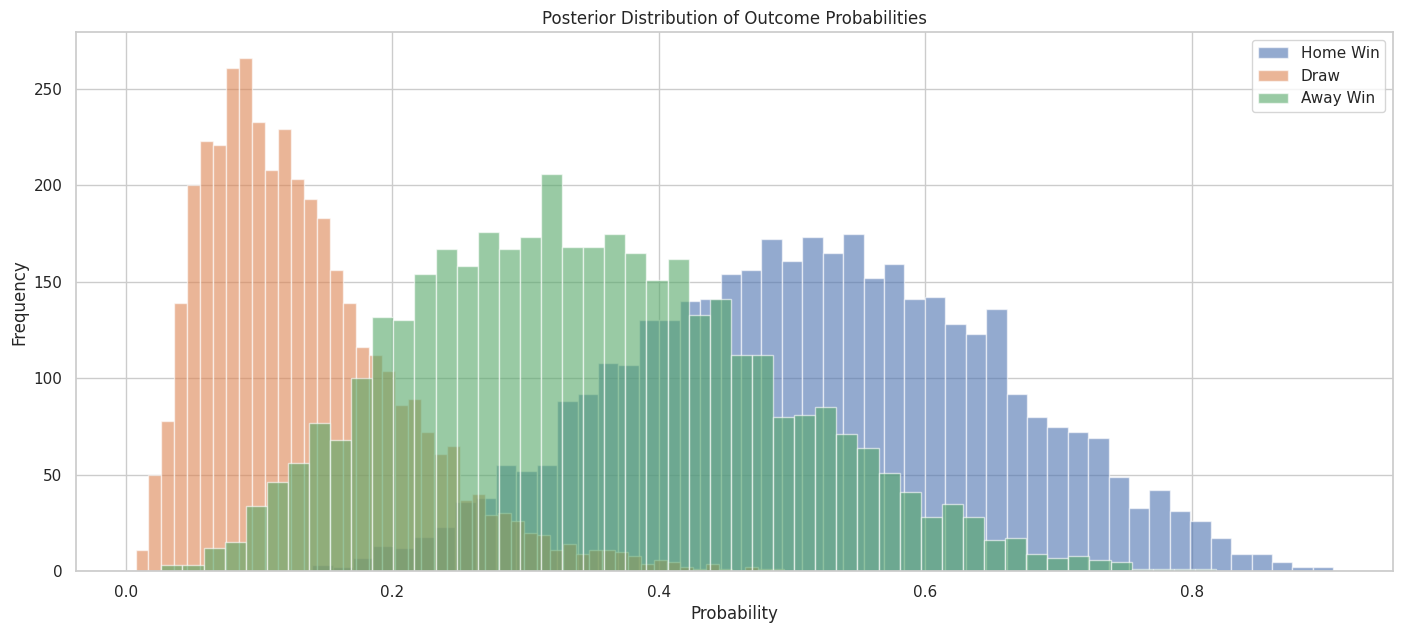

In [ ]:
import matplotlib.pyplot as plt

labels = ["Home Win", "Draw", "Away Win"]
for i, label in enumerate(labels):
    plt.hist(p_posterior[:, i], bins=50, alpha=0.6, label=label)
plt.rcParams['figure.figsize'] = (10,7)
plt.title("Posterior Distribution of Outcome Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
#This was for Arsenal vs Chelsea

**POSTERIOR DISTRIBUTION PLOTS OF BETA PARAMETERS AND INTERCEPT**

/usr/local/lib/python3.12/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (174) in plot_posterior, generating only 40 plots
  warnings.warn(


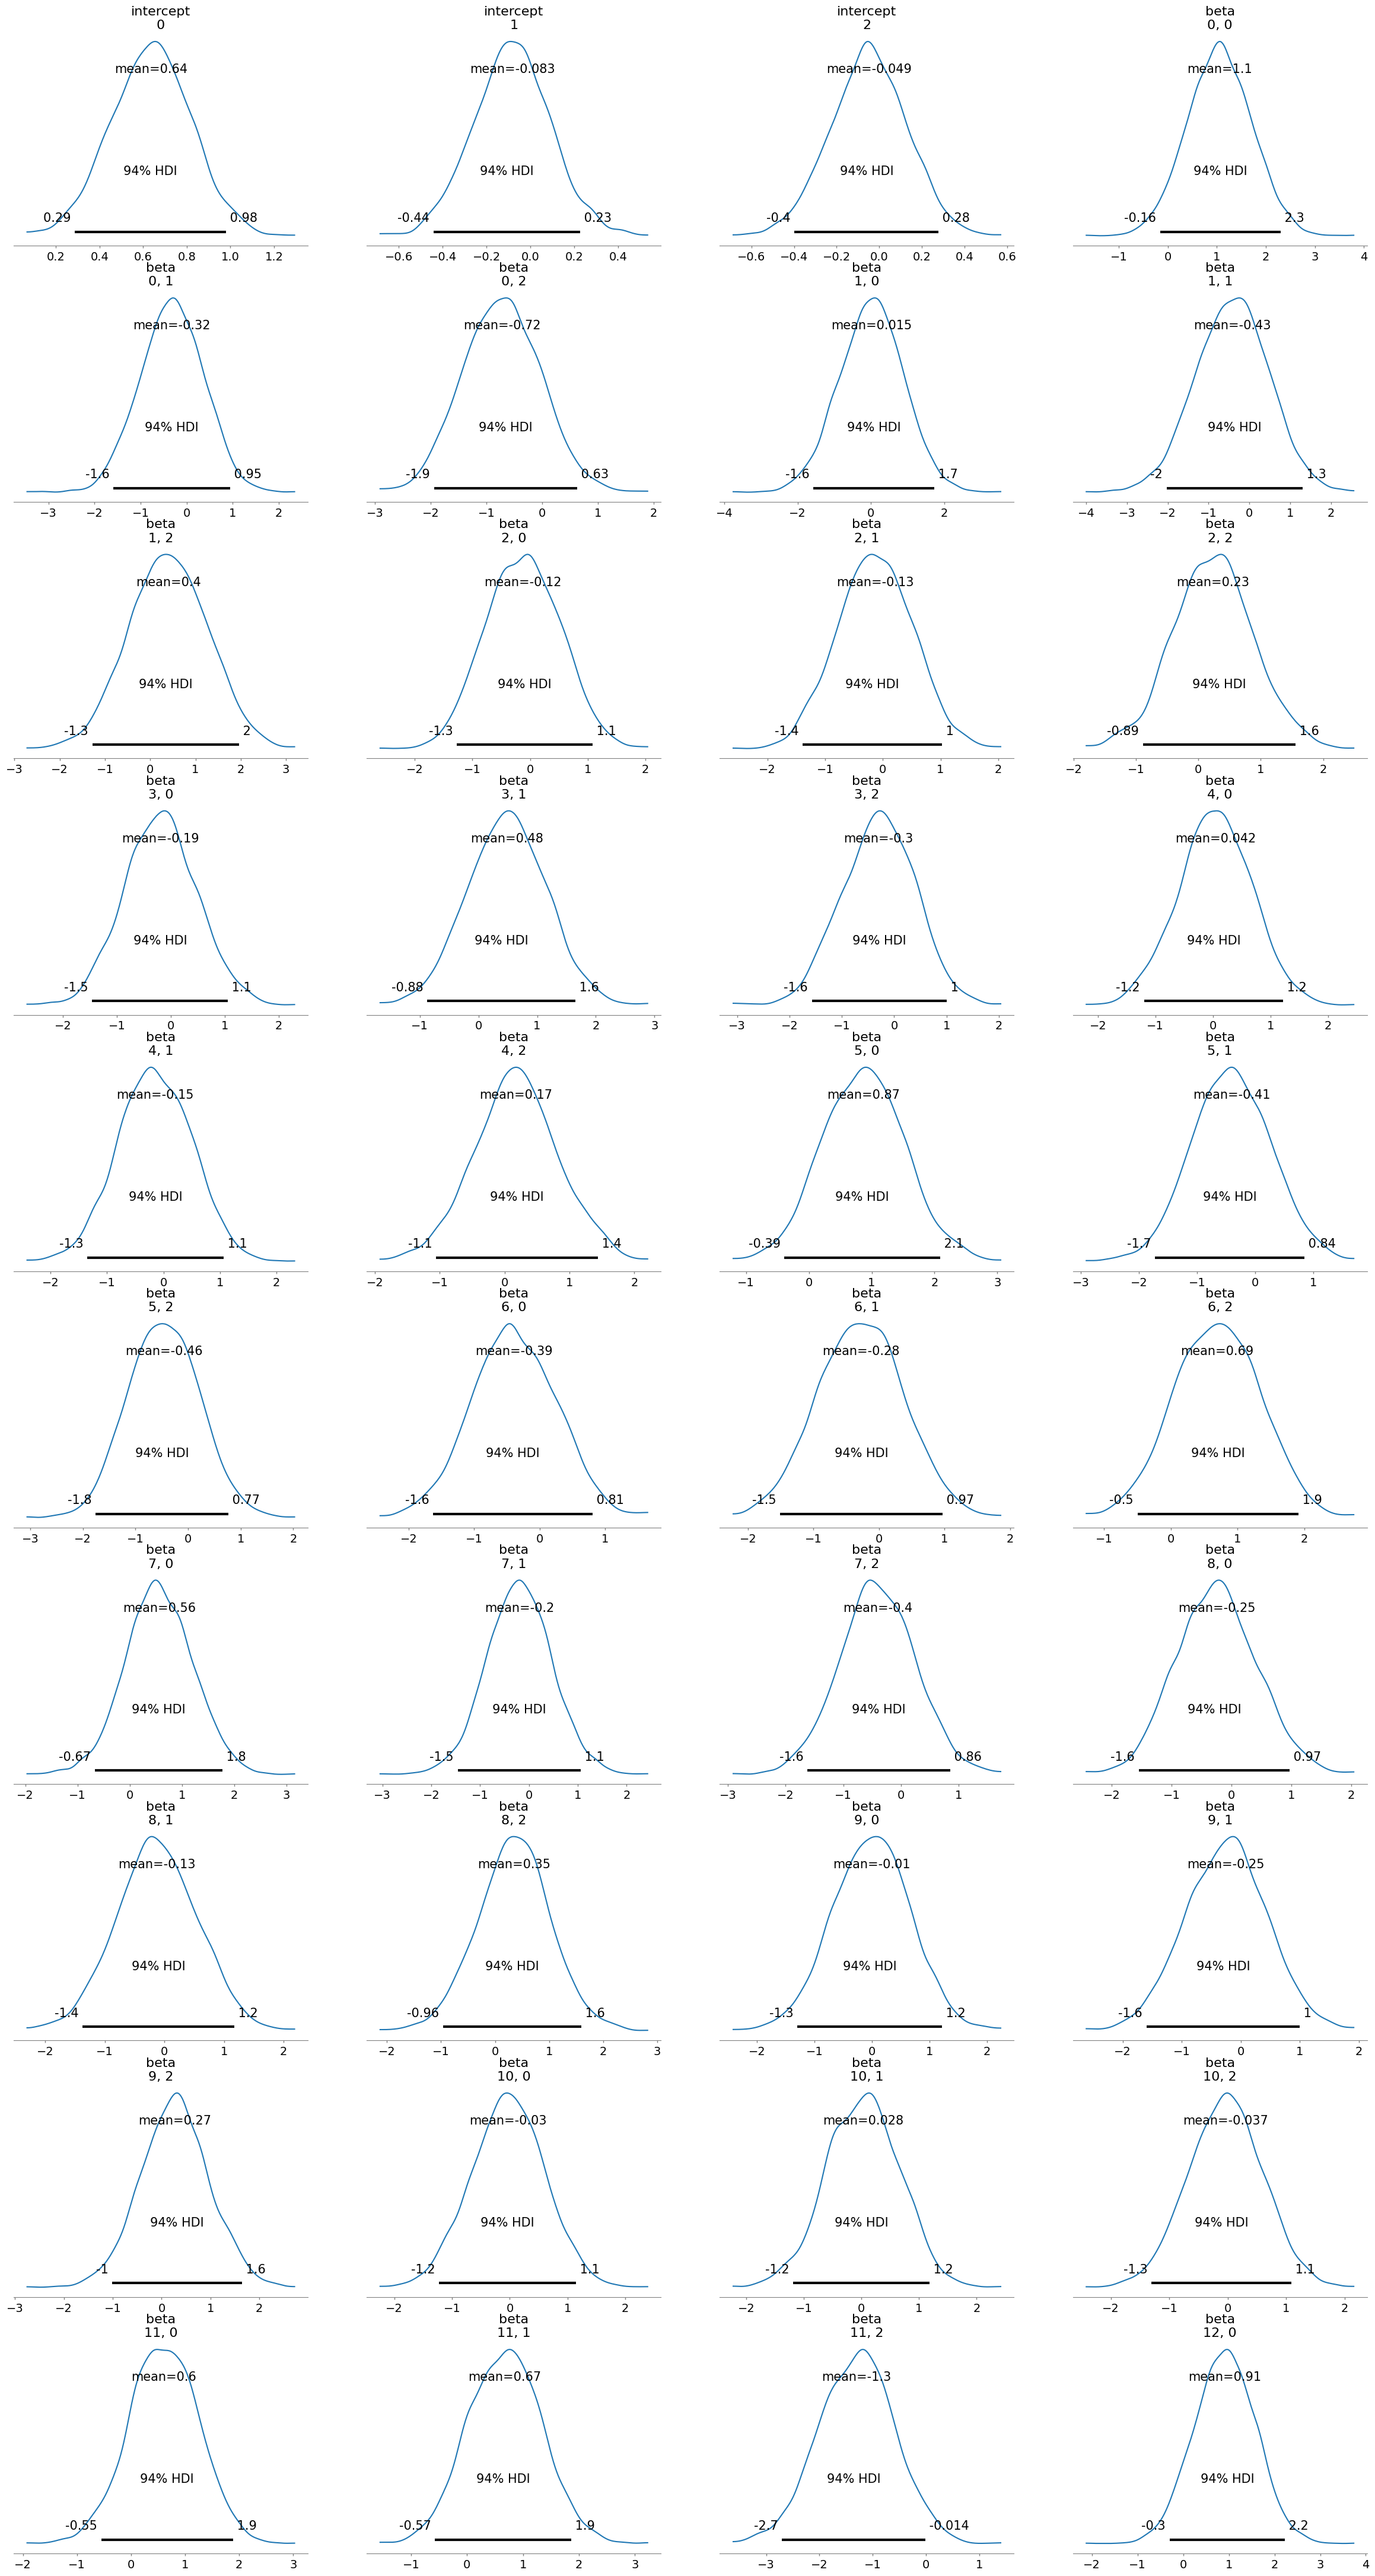

In [59]:
az.plot_posterior(trace, var_names= ['intercept','beta'])
plt.show()

# MODEL SUMMARY & CONVERGENCE

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.632,0.402,-0.106,1.398,0.005,0.007,6381.0,3297.0,1.0
"beta[0, 1]",-0.232,0.413,-1.014,0.532,0.005,0.006,5640.0,2817.0,1.0
"beta[0, 2]",-0.399,0.446,-1.255,0.435,0.006,0.008,6170.0,2877.0,1.0
"beta[1, 0]",0.024,0.398,-0.759,0.739,0.005,0.006,5289.0,3183.0,1.0
"beta[1, 1]",-0.112,0.420,-0.914,0.646,0.005,0.006,5875.0,3315.0,1.0
...,...,...,...,...,...,...,...,...,...
"p[374, 1]",0.127,0.079,0.017,0.277,0.001,0.001,5806.0,3329.0,1.0
"p[374, 2]",0.129,0.083,0.014,0.279,0.001,0.002,5745.0,3316.0,1.0
"p[375, 0]",0.445,0.127,0.212,0.679,0.002,0.002,5936.0,3460.0,1.0
"p[375, 1]",0.369,0.128,0.139,0.605,0.002,0.002,5931.0,3185.0,1.0


CREATING A LIVE SIMULATION OF POSTERIOR DISTRIBUTION UPDATES


/tmp/ipython-input-17-398831829.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")
/tmp/ipython-input-17-398831829.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")
/tmp/ipython-input-17-398831829.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


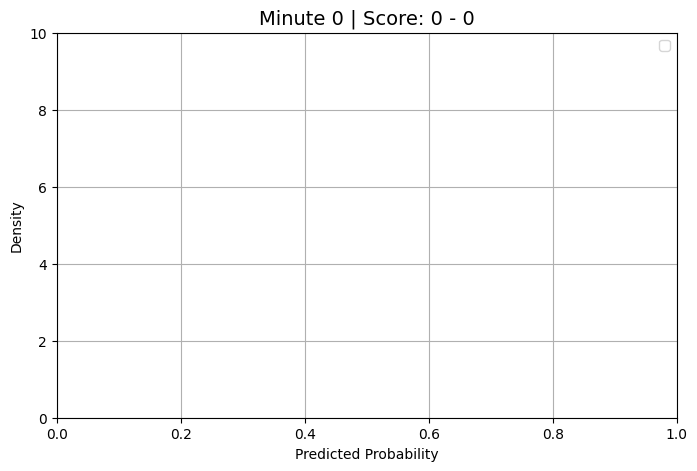

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from matplotlib.animation import FuncAnimation



beta_samples = trace.posterior['beta'].stack(sample=("chain", "draw")).values
intercept_samples = trace.posterior['intercept'].stack(sample=("chain", "draw")).values



np.random.seed(42)
n_features = 52
n_classes = 3
n_steps = 90
fps = 0.5

# Premier League priors
true_prior_probs = np.array([0.46, 0.25, 0.29])
logits_prior = np.log(true_prior_probs)

# Simulated model parameters
beta_sim = np.random.normal(0, 0.5, size=(n_features, n_classes))
intercept_sim = logits_prior
x_match = np.random.normal(0, 0.1, size=(1, n_features))


x_match = (x_match - np.mean(x_match)) / (np.std(x_match) + 1e-6)
x_match *= 0.1



event_impacts = np.random.normal(0, 0.08, size=(n_steps, n_features))


def get_avg_goals(team_name, goals_df):
    return goals_df.loc[goals_df['team'] == team_name, 'avg_goals_per_game'].values[0]

home_avg_gpg = get_avg_goals("Arsenal", goals_df)
away_avg_gpg = get_avg_goals("Chelsea", goals_df)

home_goal_prob_per_min = home_avg_gpg / 90
away_goal_prob_per_min = away_avg_gpg / 90




# Match simulation
home_goals = []
away_goals = []

probs = []
scoreline = []

for t in range(n_steps):
    # Simulate goals
    if np.random.rand() < home_goal_prob_per_min:
        home_goals.append(t)
    if np.random.rand() < away_goal_prob_per_min:
        away_goals.append(t)

    score_diff = len(home_goals) - len(away_goals)

    # Adjust intercept based on score/time
    goal_effect = np.clip(score_diff * (1 + t/90), -2, 2)
    draw_effect = -abs(score_diff) * (t / 90)
    intercept_dynamic = intercept_sim + np.array([goal_effect, draw_effect, -goal_effect])

    x_t = x_match + event_impacts[:t+1].sum(axis=0, keepdims=True)
    x_t_flat = x_t.flatten()
    logits = np.einsum('f,fcs->sc', x_t_flat, beta_samples) + intercept_samples.T
    p = softmax(logits, axis=1)
    probs.append(p.flatten())

    scoreline.append(f"{len(home_goals)} - {len(away_goals)}")

probs = np.array(probs)
categories = ["Home Win", "Draw", "Away Win"]
colors = ["blue", "gray", "tomato"]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

def update(frame):
    ax.clear()
    data = probs[:frame+1]
    for i in range(n_classes):
        try:
            sns.kdeplot(data[:, i], ax=ax, label=categories[i], fill=True, linewidth=2,
                        alpha=0.6, color=colors[i], warn_singular=False)
        except:
            continue
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    ax.set_title(f"Minute {frame} | Score: {scoreline[frame]}", fontsize=14)
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Density")
    ax.legend(loc="upper right")
    ax.grid(True)

ani = FuncAnimation(fig, update, frames=n_steps, interval=1000/fps)
ani.save("simulated_match_posterior.gif", writer="pillow", fps=fps)


LIVE CROWD AUDO SIMULATION

In [ ]:
from pydub import AudioSegment

# Load crowd effects
base = AudioSegment.from_file("crowd_base.wav").low_pass_filter(3000).apply_gain(-5)
cheer = AudioSegment.from_file("cheer_goal.wav")
buzz = AudioSegment.from_file("buzz_momentum.wav").apply_gain(-2)
boo = AudioSegment.from_file("boo_redcard.wav")

# Base ambience (3 minutes)
crowd = base * 3  # 180 seconds

# Helper: overlay at specific time
def overlay_effect(base_track, effect, time_ms):
    return base_track.overlay(effect, position=time_ms)

# Timed Events (sync with voice-over)
events = [
    (12 * 1000, buzz),       # Arsenal momentum
    (24 * 1000, cheer),      # Arsenal goal
    (32 * 1000, buzz),       # Chelsea pressure
    (45 * 1000, boo),        # Red card Chelsea
    (58 * 1000, cheer),      # Arsenal 2nd goal
    (68 * 1000, cheer),      # Chelsea goal
    (90 * 1000, cheer + cheer) # Final whistle
]

# Apply overlays
for time_ms, effect in events:
    crowd = overlay_effect(crowd, effect, time_ms)

# Export final crowd audio
crowd.export("crowd_reactions.mp3", format="mp3")


<_io.BufferedRandom name='crowd_reactions.mp3'>

This code is for extracting logs of the probabilty at given times, this is essential in syncing the generated commentary to events that reflect the posterior distribution updates

In [ ]:
# Average probabilities across samples for each frame
posterior_over_time = []

for t, p_sample in enumerate(probs):

    p_sample = p_sample.reshape(-1, 3)
    mean_probs = p_sample.mean(axis=0)

    posterior_over_time.append({
        "minute": t,
        "home_win": float(mean_probs[0]),
        "draw": float(mean_probs[1]),
        "away_win": float(mean_probs[2])
    })


In [ ]:
import pandas as pd

pd.DataFrame(posterior_over_time).to_csv("posterior_log.csv", index=False)


In [ ]:
logs =pd.read_csv('posterior_log.csv')

In [ ]:
logs.head()

,minute,home_win,draw,away_win
0,0,0.592267,0.189111,0.218622
1,1,0.573585,0.206163,0.220252
2,2,0.594364,0.192556,0.213080
3,3,0.670151,0.179450,0.150399
4,4,0.695644,0.154308,0.150048


FROM THE ABOVE PROBABILITIES, THIS IS THE CONGRUENT COMMENTARY TEXT

“Welcome one and all to this clash between Arsenal and Chelsea. Conditions are perfect, and we’re off at the Emirates! Based on recent form, Arsenal come into this with the edge — a win probability just north of 60% — but anything can happen in this fixture.”

“Early moments and Arsenal look sharp. They’re moving the ball quickly, probing down the left. Chelsea sitting back, absorbing pressure.”

“Fifteen minutes gone — still goalless. Chelsea now finding a rhythm, starting to grow into the game. Midfield battle heating up.”

“What a tackle from Saliba! That’s kept things level. The crowd appreciates that one.”

“Half an hour gone — it’s tense, tightly contested. Neither side giving an inch.”

“Now into the second half — Arsenal pushing higher. Odegaard with a cheeky through ball... just a touch too heavy. Still, the Gunners are showing real intent.”

“Minute 65 — Chelsea with a counterattack! Sterling down the wing... oh, but it’s well cut out. Danger averted.”

“And now, the moment we’ve been waiting for... minute 74 — GOAL! Bukayo Saka scores for Arsenal! A lovely finish into the bottom corner after a swift move down the right. The Emirates erupts!”

“Chelsea now chasing the game. Arsenal dropping deeper, managing the clock.”

“Final moments ticking away... Arsenal look set to take all three points. After that goal, their win probability is through the roof — Chelsea just haven’t found a response.”

“And there’s the whistle! Full time: Arsenal 1, Chelsea 0. Saka the difference-maker. What a match, and what a statement win from the Gunners!”

This text was then hooked to ElevenLabs AI to generate realistic commentary voice

THIS CODE NOW MERGES THE CROWD NOISES WITH THE COMMENTARY AND CREATES THE FINAL SIMULALATION OF THE STADIUM ATMOSPHERE


   
    Overlay two audio files and export as a single merged audio file.



In [ ]:
from pydub import AudioSegment
import os

def merge_audio_files(commentator_file, crowd_file, output_file="final_match_audio.wav"):


    try:

        print("Loading commentator audio...")
        commentator = AudioSegment.from_file(commentator_file)

        print("Loading crowd noise audio...")
        crowd = AudioSegment.from_file(crowd_file)

        # Get the duration of both files
        commentator_duration = len(commentator)
        crowd_duration = len(crowd)

        print(f"Commentator duration: {commentator_duration/1000:.2f} seconds")
        print(f"Crowd noise duration: {crowd_duration/1000:.2f} seconds")

        # Adjust lengths to match the longer file
        if commentator_duration > crowd_duration:
            # Loop the crowd noise to match commentator length
            loops_needed = (commentator_duration // crowd_duration) + 1
            crowd = crowd * loops_needed
            crowd = crowd[:commentator_duration]  # Trim to exact length
            final_duration = commentator_duration
        elif crowd_duration > commentator_duration:
            # Loop the commentator to match crowd length
            loops_needed = (crowd_duration // commentator_duration) + 1
            commentator = commentator * loops_needed
            commentator = commentator[:crowd_duration]  # Trim to exact length
            final_duration = crowd_duration
        else:
            final_duration = commentator_duration

        print(f"Final audio duration: {final_duration/1000:.2f} seconds")

        # Overlay the audio files
        print("Overlaying audio files...")
        merged_audio = commentator.overlay(crowd)

        # Export the merged audio
        print(f"Exporting merged audio to '{output_file}'...")
        merged_audio.export(output_file, format="wav")

        print(f"✅ Successfully created '{output_file}'")
        print(f"File size: {os.path.getsize(output_file) / (1024*1024):.2f} MB")

    except FileNotFoundError as e:
        print(f"❌ Error: Audio file not found - {e}")
    except Exception as e:
        print(f"❌ Error processing audio files: {e}")

def merge_with_volume_control(commentator_file, crowd_file, output_file="final_match_audio.wav",
                            commentator_volume=0, crowd_volume=-10):
    """
    Overlay two audio files with volume control and export as a single merged audio file.

    Args:
        commentator_file (str): Path to the commentator audio file
        crowd_file (str): Path to the crowd noise audio file
        output_file (str): Output filename for the merged audio
        commentator_volume (int): Volume adjustment in dB (0 = no change)
        crowd_volume (int): Volume adjustment in dB (negative = quieter)
    """

    try:
        # Load the audio files
        print("Loading audio files...")
        commentator = AudioSegment.from_file(commentator_file)
        crowd = AudioSegment.from_file(crowd_file)

        # Adjust volumes
        commentator = commentator + commentator_volume
        crowd = crowd + crowd_volume

        # Match lengths (same logic as above)
        commentator_duration = len(commentator)
        crowd_duration = len(crowd)

        if commentator_duration > crowd_duration:
            loops_needed = (commentator_duration // crowd_duration) + 1
            crowd = crowd * loops_needed
            crowd = crowd[:commentator_duration]
        elif crowd_duration > commentator_duration:
            loops_needed = (crowd_duration // commentator_duration) + 1
            commentator = commentator * loops_needed
            commentator = commentator[:crowd_duration]

        # Overlay with adjusted volumes
        print(f"Overlaying audio (Commentator: {commentator_volume}dB, Crowd: {crowd_volume}dB)...")
        merged_audio = commentator.overlay(crowd)

        # Export the merged audio
        merged_audio.export(output_file, format="wav")
        print(f"✅ Successfully created '{output_file}' with volume control")

    except Exception as e:
        print(f"❌ Error: {e}")

if __name__ == "__main__":
    # Your actual file paths
    commentator_file = "commentator.mp3"
    crowd_file = "crowd_reactions.mp3"

    # Basic merge
    merge_audio_files(commentator_file, crowd_file, "final_match_audio.wav")

    # Alternative: Merge with volume control (crowd noise quieter)
    # merge_with_volume_control(commentator_file, crowd_file,
    #                          "final_match_audio.wav",
    #                          commentator_volume=0, crowd_volume=-10)

Loading commentator audio...
Loading crowd noise audio...
Commentator duration: 191.24 seconds
Crowd noise duration: 468.91 seconds
Final audio duration: 468.91 seconds
Overlaying audio files...
Exporting merged audio to 'final_match_audio.wav'...
✅ Successfully created 'final_match_audio.wav'
File size: 85.86 MB


AND NOW WE FINALLY CREATE THE FINAL VIDEO

In [ ]:
from moviepy.editor import VideoFileClip, AudioFileClip
import os
import tempfile
import shutil

def gif_to_video_with_audio(gif_file, audio_file, output_file="match_video_with_audio.mp4"):
    """
    Convert a GIF to video and add audio background.

    Args:
        gif_file (str): Path to the GIF file
        audio_file (str): Path to the audio file
        output_file (str): Output video filename
    """

    try:
        print("Loading GIF file...")
        # Load the GIF as a video clip
        video_clip = VideoFileClip(gif_file)

        print("Loading audio file...")
        # Load the audio file
        audio_clip = AudioFileClip(audio_file)

        print(f"GIF duration: {video_clip.duration:.2f} seconds")
        print(f"Audio duration: {audio_clip.duration:.2f} seconds")

        # Handle duration differences
        if video_clip.duration > audio_clip.duration:
            # Loop the audio to match video length
            print("Audio is shorter than video - looping audio...")
            loops_needed = int(video_clip.duration / audio_clip.duration) + 1
            audio_clip = audio_clip.loop(loops_needed)
            audio_clip = audio_clip.subclip(0, video_clip.duration)
        elif audio_clip.duration > video_clip.duration:
            # Loop the video to match audio length
            print("Video is shorter than audio - looping video...")
            loops_needed = int(audio_clip.duration / video_clip.duration) + 1
            video_clip = video_clip.loop(loops_needed)
            video_clip = video_clip.subclip(0, audio_clip.duration)

        print(f"Final video duration: {video_clip.duration:.2f} seconds")

        # Add audio to video
        print("Adding audio to video...")
        final_video = video_clip.set_audio(audio_clip)

        # Create a temporary file to avoid the naming issue
        temp_file = output_file.replace('.mp4', '_temp.mp4')

        # Export the final video with fixed parameters
        print(f"Exporting video to '{temp_file}'...")
        final_video.write_videofile(
            temp_file,
            fps=24,
            codec='libx264',
            audio_codec='aac',
            temp_audiofile='temp-audio.m4a',
            remove_temp=True,
            verbose=False,
            logger=None
        )

        # Move the temp file to final output
        if os.path.exists(temp_file):
            if os.path.exists(output_file):
                os.remove(output_file)
            shutil.move(temp_file, output_file)

        print(f"✅ Successfully created '{output_file}'")

        # Clean up
        video_clip.close()
        audio_clip.close()
        final_video.close()

        # Show file info
        if os.path.exists(output_file):
            file_size = os.path.getsize(output_file) / (1024*1024)
            print(f"File size: {file_size:.2f} MB")

    except FileNotFoundError as e:
        print(f"❌ Error: File not found - {e}")
    except Exception as e:
        print(f"❌ Error creating video: {e}")
        print("Trying alternative method...")
        # Try alternative method
        try:
            create_video_alternative(gif_file, audio_file, output_file)
        except Exception as e2:
            print(f"❌ Alternative method also failed: {e2}")

def create_video_alternative(gif_file, audio_file, output_file="match_video_with_audio.mp4"):
    """
    Alternative method using different export settings.
    """
    try:
        print("Trying alternative export method...")

        # Load clips
        video_clip = VideoFileClip(gif_file)
        audio_clip = AudioFileClip(audio_file)

        # Match durations
        if video_clip.duration > audio_clip.duration:
            loops_needed = int(video_clip.duration / audio_clip.duration) + 1
            audio_clip = audio_clip.loop(loops_needed)
            audio_clip = audio_clip.subclip(0, video_clip.duration)
        elif audio_clip.duration > video_clip.duration:
            loops_needed = int(audio_clip.duration / video_clip.duration) + 1
            video_clip = video_clip.loop(loops_needed)
            video_clip = video_clip.subclip(0, audio_clip.duration)

        # Combine
        final_video = video_clip.set_audio(audio_clip)

        # Export with simpler settings
        final_video.write_videofile(
            output_file,
            fps=15,  # Lower FPS for compatibility
            codec='libx264',
            audio_codec='aac',
            bitrate='1000k',
            verbose=False,
            logger=None,
            temp_audiofile=None,
            remove_temp=True
        )

        print(f"✅ Alternative method succeeded! Created '{output_file}'")

        # Cleanup
        video_clip.close()
        audio_clip.close()
        final_video.close()

    except Exception as e:
        print(f"❌ Alternative method failed: {e}")

def simple_gif_to_video(gif_file, audio_file, output_file="match_video_simple.mp4"):
    """
    Simplified version that should work in most cases.
    """
    try:
        print("Using simplified conversion method...")

        # Load files
        video = VideoFileClip(gif_file)
        audio = AudioFileClip(audio_file)

        # Use shorter duration to avoid looping issues
        min_duration = min(video.duration, audio.duration)

        # Trim both to same length
        video = video.subclip(0, min_duration)
        audio = audio.subclip(0, min_duration)

        # Combine
        final = video.set_audio(audio)

        # Export with basic settings
        final.write_videofile(output_file, verbose=False, logger=None)

        print(f"✅ Simple method succeeded! Created '{output_file}'")

        # Cleanup
        video.close()
        audio.close()
        final.close()

    except Exception as e:
        print(f"❌ Simple method failed: {e}")

if __name__ == "__main__":
    # File paths - update these with your actual file names
    gif_file = "simulated_match_posterior (2).gif"  # Replace with your GIF filename
    audio_file = "final_match_audio.wav"  # This is the merged audio we created

    # Try the main method
    gif_to_video_with_audio(gif_file, audio_file, "match_video_with_audio.mp4")

    # If that fails, try the simple method
    # simple_gif_to_video(gif_file, audio_file, "match_video_simple.mp4")

Loading GIF file...
Loading audio file...
GIF duration: 180.00 seconds
Audio duration: 468.91 seconds
Video is shorter than audio - looping video...
Final video duration: 468.91 seconds
Adding audio to video...
Exporting video to 'match_video_with_audio_temp.mp4'...
✅ Successfully created 'match_video_with_audio.mp4'
File size: 9.26 MB
